Start with the standard imports we have used for every notebook in this class.

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

#These are one time load of SCHOOL DISTRICT data steps.
#START SECTION OF DO NOT RUN THESE AGAIN

Each of the datasheets downloaded from ELSI had download metadata on the top of them and total and key information on the bottom of them that were not data rows. This metadata, total, and key information was manually deleted before import. Some of the files had ="0" instead of 0 in the cells. This was found/replaced before import using the sed -i '' 's/="0"/0/g' *.csv command from the terminal.

In [3]:
#CITATION: This is the data from National Center for Education Statistics on Schools
#School districts for all 50 states and Washington, D.C.
#http://nces.ed.gov/ccd/elsi/
#Data Source: U.S. Department of Education National Center for Education Statistics Common Core of Data (CCD) "Local Education Agency (School District) Universe Survey" 2009-10 v.2a  2013-14 v.1a; "Public Elementary/Secondary School Universe Survey" 2009-10 v.2a; "Survey of Local Government Finances School Systems (F-33)" 2009-10 (FY 2010) v.1a.
#KEY:
#† indicates that the data are not applicable.
#– indicates that the data are missing.
#‡ indicates that the data do not meet NCES data quality standards.

districtinformation = pd.read_csv("data/rawdata/districts/2009-2010 DISTRICTS Information Tab.csv", dtype=np.str)
districtcharacteristicsa = pd.read_csv("data/rawdata/districts/2009-2010 DISTRICTS Characteristics Tab.csv", dtype=np.str)
districtenrollments = pd.read_csv("data/rawdata/districts/2009-2010 DISTRICTS Enrollments Tab.csv", dtype=np.str)
districtenrollmentK3 = pd.read_csv("data/rawdata/districts/2009-2010 DISTRICTS EnrollK3 Tab.csv", dtype=np.str)
districtenrollment48 = pd.read_csv("data/rawdata/districts/2009-2010 DISTRICTS Enroll48 Tab.csv", dtype=np.str)
districtenrollment912 = pd.read_csv("data/rawdata/districts/2009-2010 DISTRICTS Enroll912 Tab.csv", dtype=np.str)
districtteacherstaff = pd.read_csv("data/rawdata/districts/2009-2010 DISTRICTS TeacherStaff Tab.csv", dtype=np.str)
districtgeneralfinance = pd.read_csv("data/rawdata/districts/2009-2010 DISTRICTS GeneralFinance Tab.csv", dtype=np.str)
districtrevenue = pd.read_csv("data/rawdata/districts/2009-2010 DISTRICTS Revenue Tab.csv", dtype=np.str)
districtexpenditures = pd.read_csv("data/rawdata/districts/2009-2010 DISTRICTS Expenditures Tab.csv", dtype=np.str)

#Data Source: Local Education Agency (School District) Universe Survey Dropout and Completion Data: 2009-10 v.1a.

districtdropoutscompleters = pd.read_csv("data/rawdata/districts/2009-2010 DISTRICTS DropoutsCompleters.txt", dtype=np.str, delim_whitespace=True)

Check the lengths of the datasets to see if we have a row for every school district.  We more school district IDs in districtinformation than we have school district characteristics, and we have more rows of graduation information than we have school district characteristics.  Rows without school district characteristics will later be dropped.

In [4]:
print len(districtinformation)
print len(districtcharacteristicsa)
print len(districtenrollments)
print len(districtenrollmentK3)
print len(districtenrollment48)
print len(districtenrollment912)
print len(districtteacherstaff)
print len(districtgeneralfinance)
print len(districtrevenue)
print len(districtexpenditures)
print len(districtdropoutscompleters)

19023
17916
17916
17916
17916
17916
17916
17916
17916
17916
18439


Drop all of the duplicate columns.

In [5]:
#Duplicate columns are:
#Agency Name
#State Name [District] Latest available year
#Agency ID - NCES Assigned [District] Latest available year
districtenrollments = districtenrollments.drop(districtenrollments.columns[[0, 1, 2]], 1)
districtenrollmentK3 = districtenrollmentK3.drop(districtenrollmentK3.columns[[0, 1, 2]], 1)
districtenrollment48 = districtenrollment48.drop(districtenrollment48.columns[[0, 1, 2]], 1)
districtenrollment912 = districtenrollment912.drop(districtenrollment912.columns[[0, 1, 2]], 1)
districtteacherstaff = districtteacherstaff.drop(districtteacherstaff.columns[[0, 1, 2]], 1)
districtgeneralfinance = districtgeneralfinance.drop(districtgeneralfinance.columns[[0, 1, 2]], 1)
districtrevenue = districtrevenue.drop(districtrevenue.columns[[0, 1, 2]], 1)
districtexpenditures = districtexpenditures.drop(districtexpenditures.columns[[0, 1, 2]], 1)

Join all of the school district datasets. The datasets districtinformation and districtdropoutscompleters need special treatment, as they have more rows for the school districts than the other datasets. All of the other datasets can be joined by ID without issue.

In [6]:
#Join the datasets that can be joined without issue.
joineddistrict = districtcharacteristicsa.join([districtenrollments, districtenrollmentK3, districtenrollment48, districtenrollment912, districtteacherstaff, districtgeneralfinance, districtrevenue, districtexpenditures])

#Clean up an extra hidden character in the Agency Name column
joineddistrict = joineddistrict.rename(columns={'﻿Agency Name': 'Agency Name'})
districtinformation = districtinformation.rename(columns={'﻿Agency Name': 'Agency Name'})

#Merge to the districtinformation dataset
joineddistrict = districtinformation.merge(joineddistrict, 'left', 'Agency ID - NCES Assigned [District] Latest available year', suffixes=('', '_DEL'))

#Need to get rid of Excel syntax ="" from the school district ID column so it can be joined successfully
joineddistrict['Agency ID - NCES Assigned [District] Latest available year'] = joineddistrict['Agency ID - NCES Assigned [District] Latest available year'].map(lambda x: str(x).lstrip('="').rstrip('"'))

#Rename the LEAID column so it can be merged with the joineddistrict dataset
districtdropoutscompleters = districtdropoutscompleters.rename(columns={'LEAID': 'Agency ID - NCES Assigned [District] Latest available year'})

#Merge to the joineddistrict dataset
joineddistrict = joineddistrict.merge(districtdropoutscompleters, 'left', 'Agency ID - NCES Assigned [District] Latest available year', suffixes=('', '_DEL'))

#If by chance any rows have NaN, replace with the ELSI standard for missing data '–'
joineddistrict = joineddistrict.fillna('–')
joineddistrict = joineddistrict.replace('nan', '–')

joineddistrict.head()

,Agency Name,State Name [District] Latest available year,State Name [District] 2009-10,State Abbr [District] Latest available year,Agency Name [District] 2009-10,Agency ID - NCES Assigned [District] Latest available year,County Name [District] 2009-10,County Number [District] 2009-10,Race/Ethnicity Category [District] 2009-10,ANSI/FIPS State Code [District] Latest available year,Total Number Operational Schools [Public School] 2009-10,Total Number Operational Charter Schools [Public School] 2009-10,Total Number of Public Schools [Public School] 2009-10,Years District Reported Data [District] Latest available year,Years District Did Not Report Data [District] Latest available year,Location Address [District] 2013-14,Location City [District] 2013-14,Location State Abbr [District] 2013-14,Location ZIP [District] 2013-14,Location ZIP4 [District] 2013-14,Mailing Address [District] 2013-14,Mailing City [District] 2013-14,Mailing State Abbr [District] 2013-14,Mailing ZIP [District] 2013-14,Mailing ZIP4 [District] 2013-14,Phone Number [District] 2013-14,Agency Name_DEL,State Name [District] Latest available year_DEL,Agency Type [District] 2009-10,School District Level Code (SCHLEV) [District Finance] 2009-10,Urban-centric Locale [District] 2009-10,Boundary Change Indicator Flag [District] 2009-10,CBSA Name [District] 2009-10,CBSA ID [District] 2009-10,CSA Name [District] 2009-10,CSA ID [District] 2009-10,Latitude [District] 2009-10,Longitude [District] 2009-10,State Agency ID [District] 2009-10,Supervisory Union (ID) Number [District] 2009-10,Agency Charter Status [District] 2009-10,Metro Micro Area Code [District] 2009-10,Congressional Code [District] 2009-10,Census ID (CENSUSID) [District Finance] 2009-10,Lowest Grade Offered [District] 2009-10,Highest Grade Offered [District] 2009-10,Total Students (UG PK-12) [District] 2009-10,PK thru 12th Students [District] 2009-10,Ungraded Students [District] 2009-10,Total Students [Public School] 2009-10,...,Total - School Admin.- Supp. Serv. Exp. (E09) [District Finance] 2009-10,Total - Student Transp.- Supp. Serv. Exp. (V45) [District Finance] 2009-10,Total - Students- Supp. Serv. Exp. (E17) [District Finance] 2009-10,Salary - Instruction Expenditures (Z33) [District Finance] 2009-10,Salary - Students- Supp. Serv. Exp. (V11) [District Finance] 2009-10,Salary - Instruct. Staff- Supp. Serv. Exp. (V13) [District Finance] 2009-10,Salary - General Admin.- Supp. Serv. Exp. (V15) [District Finance] 2009-10,Salary - School Admin.- Supp. Serv. Exp. (V17) [District Finance] 2009-10,Salary - Ops. & Mainten.- Supp. Serv. Exp. (V21) [District Finance] 2009-10,Salary - Student Transp.- Supp. Serv. Exp. (V23) [District Finance] 2009-10,Salary - Other Supp. Serv.- Supp. Serv. Exp. (V37) [District Finance] 2009-10,Salary - Food Services- Non-Instruction (V29) [District Finance] 2009-10,Employee Benefits - Instruction Expend. (V10) [District Finance] 2009-10,Empl. Benefits - Students- Supp. Serv. Exp. (V12) [District Finance] 2009-10,Empl. Benefits - Instruction- Supp. Serv. Exp. (V14) [District Finance] 2009-10,Empl. Benefits - Gen. Adm.- Supp. Serv. Exp. (V16) [District Finance] 2009-10,Empl. Benefits - Sch. Adm.- Supp. Serv. Exp. (V18) [District Finance] 2009-10,Empl. Benefits - Ops. & Maint.- Supp. Serv. Exp. (V22) [District Finance] 2009-10,Empl. Benefits - Student Trans.- Supp. Serv. Exp. (V24) [District Finance] 2009-10,Empl. Benefits - Other Supp Serv- Supp. Serv. Exp. (V38) [District Finance] 2009-10,Empl. Benefits - Food Services- Non-Instruction (V30) [District Finance] 2009-10,Empl. Benefits - Enterp. Oper.- Non-Instruction (V32) [District Finance] 2009-10,Current Spending - Private Schools (V91) [District Finance] 2009-10,Current Spending - Public Charter Schools (V92) [District Finance] 2009-10,Teacher Salaries - Regular Education Programs (Z35) [District Finance] 2009-10,Teacher Salaries - Special Education Programs (Z36) [District Finance] 2009-10,Teacher Salaries - Vocational Education Progra

If we did this correctly, we should still have 19023 rows as we did from the previous step.

In [7]:
print len(joineddistrict)

19023


Now we start cleaning the data.

In [8]:
cleaneddistrict = joineddistrict.copy(deep=True)

In [ ]:
#SURVYEAR     1        AN       School year
#FIPST        2        AN       Two Digit American National Standards Institute (ANSI) State Code.
#
#                             	01  =  Alabama        02  =  Alaska          04  =  Arizona
#                             	05  =  Arkansas       06  =  California      08  =  Colorado
#                             	09  =  Connecticut    10  =  Delaware        11  =  District of Columbia
#                             	12  =  Florida        13  =  Georgia         15  =  Hawaii
#                             	16  =  Idaho          17  =  Illinois        18  =  Indiana
#                             	19  =  Iowa           20  =  Kansas          21  =  Kentucky
#                             	22  =  Louisiana      23  =  Maine           24  =  Maryland
#                             	25  =  Massachusetts  26  =  Michigan        27  =  Minnesota
#                             	28  =  Mississippi    29  =  Missouri        30  =  Montana
#                             	31  =  Nebraska       32  =  Nevada          33  =  New Hampshire
#                             	34  =  New Jersey     35  =  New Mexico      36  =  New York
#                             	37  =  North Carolina 38  =  North Dakota    39  =  Ohio
#                             	40  =  Oklahoma       41  =  Oregon          42  =  Pennsylvania
#                             	44  =  Rhode Island   45  =  South Carolina  46  =  South Dakota
#                             	47  =  Tennessee      48  =  Texas           49  =  Utah
#                             	50  =  Vermont        51  =  Virginia        53  =  Washington
#                             	54  =  West Virginia  55  =  Wisconsin       56  =  Wyoming
#                             	58  =  DOD Dependents Schools-Overseas    
#                             	59  =  Bureau of Indian Education
#                             	60  =  American Samoa 61  =  DOD Dependents School-Domestic
#                             	66  =  Guam           69  =  Northern Marianas
#                             	72  =  Puerto Rico    78  =  Virgin Islands
#
#LEAID        3        AN       NCES Assigned Local Education Agency Identification Number
#TOTD912      4        N        Total Dropouts, Grades 9–12
#EBS912       5        N        Dropout Enrollment Base, Grades 9–12
#DRP912       6*       N        Dropout Rate, Grades 9–12
#TOTDPL       7        N        Total Diploma Count
#AFGEB        8        N        Total Averaged Freshman Graduation Rate (AFGR) Enrollment Base
#AFGR         9*       N        Total Averaged Freshmen Graduation Rate (AFGR)
#TOTOHC      10        N        Total Other High School Completion Certificate (OHC) Recipients

#TOTD912 - -3 = ; -2 = DOESN'T HAVE GRADUATES - ELEM OR MIDDLE; -9
#EBS912 - 100 = ; -2 = DOESN'T HAVE GRADUATES - ELEM OR MIDDLE
#DRP912 - -3 = ; -2.0 = DOESN'T HAVE GRADUATES - ELEM OR MIDDLE
#TOTDPL - -2 = DOESN'T HAVE GRADUATES - ELEM OR MIDDLE
#AFGEB - -2 = DOESN'T HAVE GRADUATES - ELEM OR MIDDLE
#AFGR - -2.0 = DOESN'T HAVE GRADUATES - ELEM OR MIDDLE
#TOTOHC - -2 = DOESN'T HAVE GRADUATES - ELEM OR MIDDLE

This dataset has flags for different types of missing data (NAs, missing, etc.), including -1, -2, -3, -4, -9. Set all of these to missing data flag instead.

In [9]:
cleaneddistrict['TOTD912'] = cleaneddistrict['TOTD912'].replace('-1', '–')
cleaneddistrict['TOTD912'] = cleaneddistrict['TOTD912'].replace('-2', '–')
cleaneddistrict['TOTD912'] = cleaneddistrict['TOTD912'].replace('-3', '–')
cleaneddistrict['TOTD912'] = cleaneddistrict['TOTD912'].replace('-4', '–')
cleaneddistrict['TOTD912'] = cleaneddistrict['TOTD912'].replace('-9', '–')

cleaneddistrict['EBS912'] = cleaneddistrict['EBS912'].replace('-2', '–')

cleaneddistrict['DRP912'] = cleaneddistrict['DRP912'].replace('-1.0', '–')
cleaneddistrict['DRP912'] = cleaneddistrict['DRP912'].replace('-2.0', '–')
cleaneddistrict['DRP912'] = cleaneddistrict['DRP912'].replace('-3.0', '–')
cleaneddistrict['DRP912'] = cleaneddistrict['DRP912'].replace('-4.0', '–')
cleaneddistrict['DRP912'] = cleaneddistrict['DRP912'].replace('-9.0', '–')

cleaneddistrict['TOTDPL'] = cleaneddistrict['TOTDPL'].replace('-1', '–')
cleaneddistrict['TOTDPL'] = cleaneddistrict['TOTDPL'].replace('-2', '–')
cleaneddistrict['TOTDPL'] = cleaneddistrict['TOTDPL'].replace('-9', '–')

cleaneddistrict['AFGEB'] = cleaneddistrict['AFGEB'].replace('-1', '–')
cleaneddistrict['AFGEB'] = cleaneddistrict['AFGEB'].replace('-2', '–')

cleaneddistrict['AFGR'] = cleaneddistrict['AFGR'].replace('-1.0', '–')
cleaneddistrict['AFGR'] = cleaneddistrict['AFGR'].replace('-2.0', '–')
cleaneddistrict['AFGR'] = cleaneddistrict['AFGR'].replace('-9.0', '–')

cleaneddistrict['TOTOHC'] = cleaneddistrict['TOTOHC'].replace('-1', '–')
cleaneddistrict['TOTOHC'] = cleaneddistrict['TOTOHC'].replace('-2', '–')
cleaneddistrict['TOTOHC'] = cleaneddistrict['TOTOHC'].replace('-3', '–')
cleaneddistrict['TOTOHC'] = cleaneddistrict['TOTOHC'].replace('-9', '–')

In [10]:
#Need to get rid of Excel syntax ="" from some of the columns
for i, col in enumerate(cleaneddistrict.columns):
    cleaneddistrict[col] = cleaneddistrict[col].map(lambda x: str(x).lstrip('="').rstrip('"'))

In [11]:
# Replacing Missing Data / NA / Bad Quality data with NaN
# Ref : http://pandas.pydata.org/pandas-docs/version/0.15.2/missing_data.html

cleaneddistrict = cleaneddistrict.replace('\xe2\x80\x93', '') # Replace "-" (Missing Data) with NaN
cleaneddistrict = cleaneddistrict.replace('\xe2\x80\xa0', '') # Replace "†" (Not Applicable) with NaN
cleaneddistrict = cleaneddistrict.replace('\xe2\x80\xa1', '') # Replace "‡" (Bad Quality) with NaN

Turn all of the numerical columns into floats.

In [12]:
countcolumns = ['Local Rev. - Individual & Corp. Income Taxes (T40) [District Finance] 2009-10','Local Rev. - All Other Taxes (T99) [District Finance] 2009-10','Local Rev. - Parent Government Contributions (T02) [District Finance] 2009-10','Local Rev. - Revenue- Cities and Counties (D23) [District Finance] 2009-10','Local Rev. - Revenue- Other School Systems (D11) [District Finance] 2009-10','Local Rev. - Tuition Fees- Pupils and Parents (A07) [District Finance] 2009-10','Local Rev. - Transp. Fees- Pupils and Parents (A08) [District Finance] 2009-10','Local Rev. - School Lunch Revenues (A09) [District Finance] 2009-10','Local Rev. - Textbook Sales and Rentals (A11) [District Finance] 2009-10','Local Rev. - Student Activity Receipts (A13) [District Finance] 2009-10','Local Rev. - Other Sales and Service Rev. (A20) [District Finance] 2009-10','Local Rev. - Student Fees Non-Specified (A15) [District Finance] 2009-10','Local Rev. - Interest Earnings (U22) [District Finance] 2009-10','Local Rev. - Miscellaneous Other Local Rev. (U97) [District Finance] 2009-10','Local Rev. - Special Processing (C24) [District Finance] 2009-10','Local Rev. - Rents and Royalties (A40) [District Finance] 2009-10','Local Rev. - Sale of Property (U11) [District Finance] 2009-10','Local Rev. - Fines and Forfeits (U30) [District Finance] 2009-10','Local Rev. - Private Contributions (U50) [District Finance] 2009-10','State Rev. - General Formula Assistance (C01) [District Finance] 2009-10','State Rev. - Special Education Programs (C05) [District Finance] 2009-10','State Rev. - Transportation Programs (C12) [District Finance] 2009-10','State Rev. - Staff Improvement Programs (C04) [District Finance] 2009-10','State Rev. - Compensat. and Basic Skills Prog. (C06) [District Finance] 2009-10','State Rev. - Vocational Education Programs (C09) [District Finance] 2009-10','State Rev. - Capital Outlay and Debt Serv. Prog. (C11) [District Finance] 2009-10','State Rev. - Bilingual Education Programs (C07) [District Finance] 2009-10','State Rev. - Gifted and Talented Programs (C08) [District Finance] 2009-10','State Rev. - School Lunch Programs (C10) [District Finance] 2009-10','State Rev. - All Other Rev.- State Sources (C13) [District Finance] 2009-10','State Rev. - State Payment for LEA Empl. Benefits (C38) [District Finance] 2009-10','State Rev. - Other State Payments (C39) [District Finance] 2009-10','State Rev. - Non-Specified (C35) [District Finance] 2009-10','Federal Rev. - Federal Title I Revenue (C14) [District Finance] 2009-10','Federal Rev. - Children with Disabilities (C15) [District Finance] 2009-10','Federal Rev. - Child Nutrition Act (C25) [District Finance] 2009-10','Federal Rev. - Eisenhower Math and Science (C16) [District Finance] 2009-10','Federal Rev. - Drug-Free Schools (C17) [District Finance] 2009-10','Federal Rev. - Vocational Education (C19) [District Finance] 2009-10','Federal Rev. - All Other Fed. Aid Through State (C20) [District Finance] 2009-10','Federal Rev. - Nonspecified (C36) [District Finance] 2009-10','Federal Rev. - Impact Aid (PL 815 and 874) (B10) [District Finance] 2009-10','Federal Rev. - Bilingual Education (B11) [District Finance] 2009-10','Federal Rev. - Native American (Ind.) Educ. (B12) [District Finance] 2009-10','Federal Rev. - All Other Federal Aid (B13) [District Finance] 2009-10','Enterprise Operations - Non Instructional (V60) [District Finance] 2009-10','Food Services - Non Instuctional (E11) [District Finance] 2009-10','Instruction Expenditures - Total (E13) [District Finance] 2009-10','Non-Specified - Supp. Serv. Exp. (V85) [District Finance] 2009-10','Other Non Instructional (V65) [District Finance] 2009-10','Total - Gen. Admin.- Supp. Serv. Exp. (E08) [District Finance] 2009-10','Total - Instruct. Staff- Supp. Serv. Exp. (E07) [District Finance] 2009-10','Total - Ops. & Mainten.- Supp. Serv. Exp. (V40) [District Finance] 2009-10','Total - Other Supp. Serv.- Supp. Serv. Exp. (V90) [District Finance] 2009-10','Total - School Admin.- Supp. Serv. Exp. (E09) [District Finance] 2009-10','Total - Student Transp.- Supp. Serv. Exp. (V45) [District Finance] 2009-10','Total - Students- Supp. Serv. Exp. (E17) [District Finance] 2009-10','Salary - Instruction Expenditures (Z33) [District Finance] 2009-10','Salary - Students- Supp. Serv. Exp. (V11) [District Finance] 2009-10','Salary - Instruct. Staff- Supp. Serv. Exp. (V13) [District Finance] 2009-10','Salary - General Admin.- Supp. Serv. Exp. (V15) [District Finance] 2009-10','Salary - School Admin.- Supp. Serv. Exp. (V17) [District Finance] 2009-10','Salary - Ops. & Mainten.- Supp. Serv. Exp. (V21) [District Finance] 2009-10','Salary - Student Transp.- Supp. Serv. Exp. (V23) [District Finance] 2009-10','Salary - Other Supp. Serv.- Supp. Serv. Exp. (V37) [District Finance] 2009-10','Salary - Food Services- Non-Instruction (V29) [District Finance] 2009-10','Employee Benefits - Instruction Expend. (V10) [District Finance] 2009-10','Empl. Benefits - Students- Supp. Serv. Exp. (V12) [District Finance] 2009-10','Empl. Benefits - Instruction- Supp. Serv. Exp. (V14) [District Finance] 2009-10','Empl. Benefits - Gen. Adm.- Supp. Serv. Exp. (V16) [District Finance] 2009-10','Empl. Benefits - Sch. Adm.- Supp. Serv. Exp. (V18) [District Finance] 2009-10','Empl. Benefits - Ops. & Maint.- Supp. Serv. Exp. (V22) [District Finance] 2009-10','Empl. Benefits - Student Trans.- Supp. Serv. Exp. (V24) [District Finance] 2009-10','Empl. Benefits - Other Supp Serv- Supp. Serv. Exp. (V38) [District Finance] 2009-10','Empl. Benefits - Food Services- Non-Instruction (V30) [District Finance] 2009-10','Empl. Benefits - Enterp. Oper.- Non-Instruction (V32) [District Finance] 2009-10','Current Spending - Private Schools (V91) [District Finance] 2009-10','Current Spending - Public Charter Schools (V92) [District Finance] 2009-10','Teacher Salaries - Regular Education Programs (Z35) [District Finance] 2009-10','Teacher Salaries - Special Education Programs (Z36) [District Finance] 2009-10','Teacher Salaries - Vocational Education Programs (Z37) [District Finance] 2009-10','Teacher Salaries - Other Education Programs (Z38) [District Finance] 2009-10','Textbooks for Instruction (V93) [District Finance] 2009-10','Community Services - Non El-Sec (V70) [District Finance] 2009-10','Adult Education - Non El-Sec (V75) [District Finance] 2009-10','Other Expenditures - Non El-Sec (V80) [District Finance] 2009-10','Construction - Capital Outlay (F12) [District Finance] 2009-10','Instructional Equipment - Capital Outlay (K09) [District Finance] 2009-10','Other Equipment - Capital Outlay (K10) [District Finance] 2009-10','Non-specified - Equipment Expenditures (K11) [District Finance] 2009-10','Land & Existing Structures - Capital Outlay (G15) [District Finance] 2009-10','Payments to Local Governments (M12) [District Finance] 2009-10','Payments to State Governments (L12) [District Finance] 2009-10','Interest on School System Indebtedness (I86) [District Finance] 2009-10','Payments to Other School Systems (Q11) [District Finance] 2009-10','FIPST','TOTD912','EBS912','DRP912','TOTDPL','AFGEB','AFGR','TOTOHC','Total Number Operational Schools [Public School] 2009-10', 'Total Number Operational Charter Schools [Public School] 2009-10', 'Total Number of Public Schools [Public School] 2009-10', 'Total Students (UG PK-12) [District] 2009-10', 'PK thru 12th Students [District] 2009-10', 'Ungraded Students [District] 2009-10', 'Total Students [Public School] 2009-10', 'Limited English Proficient (LEP) / English Language Learners (ELL) [District] 2009-10', 'Individualized Education Program Students [District] 2009-10', 'Free Lunch Eligible [Public School] 2009-10', 'Reduced-price Lunch Eligible Students [Public School] 2009-10', 'Total Free and Reduced Lunch Students [Public School] 2009-10', 'Prekindergarten and Kindergarten Students [Public School] 2009-10', 'Grades 1-8 Students [Public School] 2009-10','Grades 9-12 Students [Public School] 2009-10','Prekindergarten Students [Public School] 2009-10','Kindergarten Students [Public School] 2009-10','Grade 1 Students [Public School] 2009-10','Grade 2 Students [Public School] 2009-10','Grade 3 Students [Public School] 2009-10','Grade 4 Students [Public School] 2009-10','Grade 5 Students [Public School] 2009-10','Grade 6 Students [Public School] 2009-10','Grade 7 Students [Public School] 2009-10','Grade 8 Students [Public School] 2009-10','Grade 9 Students [Public School] 2009-10','Grade 10 Students [Public School] 2009-10','Grade 11 Students [Public School] 2009-10','Grade 12 Students [Public School] 2009-10','Ungraded Students [Public School] 2009-10','Male Students [Public School] 2009-10','Female Students [Public School] 2009-10','American Indian/Alaska Native Students [Public School] 2009-10','Asian or Asian/Pacific Islander Students [Public School] 2009-10','Hispanic Students [Public School] 2009-10','Black Students [Public School] 2009-10','White Students [Public School] 2009-10','Hawaiian Nat./Pacific Isl. Students [Public School] 2009-10','Two or More Races Students [Public School] 2009-10','Total Race/Ethnicity [Public School] 2009-10','Prekindergarten Students - American Indian/Alaska Native - male [Public School] 2009-10','Prekindergarten Students - American Indian/Alaska Native - female [Public School] 2009-10','Prekindergarten Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10','Prekindergarten Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10','Prekindergarten Students - Hispanic - male [Public School] 2009-10','Prekindergarten Students - Hispanic - female [Public School] 2009-10','Prekindergarten Students - Black - male [Public School] 2009-10','Prekindergarten Students - Black - female [Public School] 2009-10','Prekindergarten Students - White - male [Public School] 2009-10','Prekindergarten Students - White - female [Public School] 2009-10','Prekindergarten Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10','Prekindergarten Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10','Prekindergarten Students - Two or More Races - male [Public School] 2009-10','Prekindergarten Students - Two or More Races - female [Public School] 2009-10','Kindergarten Students - American Indian/Alaska Native - male [Public School] 2009-10','Kindergarten Students - American Indian/Alaska Native - female [Public School] 2009-10','Kindergarten Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10','Kindergarten Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10','Kindergarten Students - Hispanic - male [Public School] 2009-10','Kindergarten Students - Hispanic - female [Public School] 2009-10','Kindergarten Students - Black - male [Public School] 2009-10','Kindergarten Students - Black - female [Public School] 2009-10','Kindergarten Students - White - male [Public School] 2009-10','Kindergarten Students - White - female [Public School] 2009-10','Kindergarten Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10','Kindergarten Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10','Kindergarten Students - Two or More Races - male [Public School] 2009-10','Kindergarten Students - Two or More Races - female [Public School] 2009-10','Grade 1 Students - American Indian/Alaska Native - male [Public School] 2009-10','Grade 1 Students - American Indian/Alaska Native - female [Public School] 2009-10','Grade 1 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10','Grade 1 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10','Grade 1 Students - Hispanic - male [Public School] 2009-10','Grade 1 Students - Hispanic - female [Public School] 2009-10','Grade 1 Students - Black - male [Public School] 2009-10','Grade 1 Students - Black - female [Public School] 2009-10','Grade 1 Students - White - male [Public School] 2009-10','Grade 1 Students - White - female [Public School] 2009-10','Grade 1 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10','Grade 1 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10','Grade 1 Students - Two or More Races - male [Public School] 2009-10','Grade 1 Students - Two or More Races - female [Public School] 2009-10','Grade 2 Students - American Indian/Alaska Native - male [Public School] 2009-10','Grade 2 Students - American Indian/Alaska Native - female [Public School] 2009-10','Grade 2 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10','Grade 2 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10','Grade 2 Students - Hispanic - male [Public School] 2009-10','Grade 2 Students - Hispanic - female [Public School] 2009-10','Grade 2 Students - Black - male [Public School] 2009-10','Grade 2 Students - Black - female [Public School] 2009-10','Grade 2 Students - White - male [Public School] 2009-10','Grade 2 Students - White - female [Public School] 2009-10','Grade 2 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10','Grade 2 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10','Grade 2 Students - Two or More Races - male [Public School] 2009-10','Grade 2 Students - Two or More Races - female [Public School] 2009-10','Grade 3 Students - American Indian/Alaska Native - male [Public School] 2009-10','Grade 3 Students - American Indian/Alaska Native - female [Public School] 2009-10','Grade 3 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10','Grade 3 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10','Grade 3 Students - Hispanic - male [Public School] 2009-10','Grade 3 Students - Hispanic - female [Public School] 2009-10','Grade 3 Students - Black - male [Public School] 2009-10','Grade 3 Students - Black - female [Public School] 2009-10','Grade 3 Students - White - male [Public School] 2009-10','Grade 3 Students - White - female [Public School] 2009-10','Grade 3 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10','Grade 3 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10','Grade 3 Students - Two or More Races - male [Public School] 2009-10','Grade 3 Students - Two or More Races - female [Public School] 2009-10','Grade 4 Students - American Indian/Alaska Native - male [Public School] 2009-10','Grade 4 Students - American Indian/Alaska Native - female [Public School] 2009-10','Grade 4 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10','Grade 4 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10','Grade 4  Students - Hispanic - male [Public School] 2009-10','Grade 4 Students - Hispanic - female [Public School] 2009-10','Grade 4 Students - Black - male [Public School] 2009-10','Grade 4 Students - Black - female [Public School] 2009-10','Grade 4 Students - White - male [Public School] 2009-10','Grade 4 Students - White - female [Public School] 2009-10','Grade 4 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10','Grade 4 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10','Grade 4 Students - Two or More Races - male [Public School] 2009-10','Grade 4 Students - Two or More Races - female [Public School] 2009-10','Grade 5 Students - American Indian/Alaska Native - male [Public School] 2009-10','Grade 5 Students - American Indian/Alaska Native - female [Public School] 2009-10','Grade 5 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10','Grade 5 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10','Grade 5 Students - Hispanic - male [Public School] 2009-10','Grade 5 Students - Hispanic - female [Public School] 2009-10','Grade 5 Students - Black - male [Public School] 2009-10','Grade 5 Students - Black - female [Public School] 2009-10','Grade 5 Students - White - male [Public School] 2009-10','Grade 5 Students - White - female [Public School] 2009-10','Grade 5 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10','Grade 5 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10','Grade 5 Students - Two or More Races - male [Public School] 2009-10','Grade 5 Students - Two or More Races - female [Public School] 2009-10','Grade 6 Students - American Indian/Alaska Native - male [Public School] 2009-10','Grade 6 Students - American Indian/Alaska Native - female [Public School] 2009-10','Grade 6 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10','Grade 6 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10','Grade 6 Students - Hispanic - male [Public School] 2009-10','Grade 6 Students - Hispanic - female [Public School] 2009-10','Grade 6 Students - Black - male [Public School] 2009-10','Grade 6 Students - Black - female [Public School] 2009-10','Grade 6 Students - White - male [Public School] 2009-10','Grade 6 Students - White - female [Public School] 2009-10','Grade 6 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10','Grade 6 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10','Grade 6  Students- Two or More Races - male [Public School] 2009-10','Grade 6 Students - Two or More Races - female [Public School] 2009-10','Grade 7 Students - American Indian/Alaska Native - male [Public School] 2009-10','Grade 7 Students - American Indian/Alaska Native - female [Public School] 2009-10','Grade 7 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10','Grade 7 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10','Grade 7 Students - Hispanic - male [Public School] 2009-10','Grade 7 Students - Hispanic - female [Public School] 2009-10','Grade 7 Students - Black - male [Public School] 2009-10','Grade 7 Students - Black - female [Public School] 2009-10', 'Grade 7 Students - White - male [Public School] 2009-10','Grade 7 Students - White - female [Public School] 2009-10','Grade 7 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10','Grade 7 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10','Grade 7 Students - Two or More Races - male [Public School] 2009-10','Grade 7 Students - Two or More Races - female [Public School] 2009-10','Grade 8 Students - American Indian/Alaska Native - male [Public School] 2009-10','Grade 8 Students - American Indian/Alaska Native - female [Public School] 2009-10','Grade 8 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10','Grade 8 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10','Grade 8  Students- Hispanic - male [Public School] 2009-10','Grade 8 Students - Hispanic - female [Public School] 2009-10','Grade 8 Students - Black - male [Public School] 2009-10','Grade 8 Students - Black - female [Public School] 2009-10','Grade 8 Students - White - male [Public School] 2009-10','Grade 8 Students - White - female [Public School] 2009-10','Grade 8 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10','Grade 8 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10','Grade 8 Students - Two or More Races - male [Public School] 2009-10','Grade 8 Students - Two or More Races - female [Public School] 2009-10','Grade 9 Students - American Indian/Alaska Native - male [Public School] 2009-10','Grade 9 Students - American Indian/Alaska Native - female [Public School] 2009-10','Grade 9 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10','Grade 9 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10','Grade 9 Students - Hispanic - male [Public School] 2009-10','Grade 9 Students - Hispanic - female [Public School] 2009-10','Grade 9 Students - Black - male [Public School] 2009-10','Grade 9 Students - Black - female [Public School] 2009-10','Grade 9 Students - White - male [Public School] 2009-10','Grade 9 Students - White - female [Public School] 2009-10','Grade 9 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10','Grade 9 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10','Grade 9 Students - Two or More Races - male [Public School] 2009-10','Grade 9 Students - Two or More Races - female [Public School] 2009-10','Grade 10 Students - American Indian/Alaska Native - male [Public School] 2009-10','Grade 10 Students - American Indian/Alaska Native - female [Public School] 2009-10','Grade 10 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10','Grade 10 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10','Grade 10 Students - Hispanic - male [Public School] 2009-10','Grade 10 Students - Hispanic - female [Public School] 2009-10','Grade 10 Students - Black - male [Public School] 2009-10','Grade 10 Students - Black - female [Public School] 2009-10','Grade 10 Students - White - male [Public School] 2009-10','Grade 10 Students - White - female [Public School] 2009-10','Grade 10 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10','Grade 10 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10','Grade 10 Students - Two or More Races - male [Public School] 2009-10','Grade 10 Students - Two or More Races - female [Public School] 2009-10','Grade 11 Students - American Indian/Alaska Native - male [Public School] 2009-10','Grade 11 Students - American Indian/Alaska Native - female [Public School] 2009-10','Grade 11 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10','Grade 11 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10','Grade 11 Students - Hispanic - male [Public School] 2009-10','Grade 11 Students - Hispanic - female [Public School] 2009-10','Grade 11 Students - Black - male [Public School] 2009-10','Grade 11 Students - Black - female [Public School] 2009-10','Grade 11 Students - White - male [Public School] 2009-10','Grade 11 Students - White - female [Public School] 2009-10','Grade 11 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10','Grade 11 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10','Grade 11 Students - Two or More Races - male [Public School] 2009-10','Grade 11 Students - Two or More Races - female [Public School] 2009-10','Grade 12 Students - American Indian/Alaska Native - male [Public School] 2009-10','Grade 12 Students - American Indian/Alaska Native - female [Public School] 2009-10','Grade 12 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10','Grade 12 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10','Grade 12 Students - Hispanic - male [Public School] 2009-10','Grade 12 Students - Hispanic - female [Public School] 2009-10','Grade 12 Students - Black - male [Public School] 2009-10','Grade 12 Students - Black - female [Public School] 2009-10','Grade 12 Students - White - male [Public School] 2009-10','Grade 12 Students - White - female [Public School] 2009-10','Grade 12 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10','Grade 12 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10','Grade 12 Students - Two or More Races - male [Public School] 2009-10','Grade 12 Students - Two or More Races - female [Public School] 2009-10','Ungraded Students - American Indian/Alaska Native - male [Public School] 2009-10','Ungraded  Students- American Indian/Alaska Native - female [Public School] 2009-10','Ungraded Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10','Ungraded Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10','Ungraded Students - Hispanic - male [Public School] 2009-10','Ungraded Students - Hispanic - female [Public School] 2009-10','Ungraded Students - Black - male [Public School] 2009-10','Ungraded Students - Black - female [Public School] 2009-10','Ungraded Students - White - male [Public School] 2009-10','Ungraded Students - White - female [Public School] 2009-10','Ungraded Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10','Ungraded Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10','Ungraded Students - Two or More Races - male [Public School] 2009-10','Ungraded Students - Two or More Races - female [Public School] 2009-10','Full-Time Equivalent (FTE) Teachers [District] 2009-10','Full-Time Equivalent (FTE) Teachers [Public School] 2009-10','Pupil/Teacher Ratio [District] 2009-10','Pupil/Teacher Ratio [Public School] 2009-10','Prekindergarten Teachers [District] 2009-10','Kindergarten Teachers [District] 2009-10','Elementary Teachers [District] 2009-10','Secondary Teachers [District] 2009-10','Ungraded Teachers [District] 2009-10','Total Staff [District] 2009-10','Instructional Aides [District] 2009-10','Instructional Coordinators [District] 2009-10','Elementary Guidance Counselors [District] 2009-10','Secondary Guidance Counselors [District] 2009-10','Other Guidance Counselors [District] 2009-10','Total Guidance Counselors [District] 2009-10','Librarians/Media Specialists [District] 2009-10','Library Media Support Staff [District] 2009-10','LEA Administrators [District] 2009-10','LEA Administrative Support Staff [District] 2009-10','School Administrators [District] 2009-10','School Administrative Support Staff [District] 2009-10','Student Support Services Staff [District] 2009-10','Other Support Services Staff [District] 2009-10','Fall Membership (V33) [District Finance] 2009-10','Total General Revenue (TOTALREV) [District Finance] 2009-10','Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10','Total Revenue - State Sources (TSTREV) [District Finance] 2009-10','Total Revenue - Federal Sources (TFEDREV) [District Finance] 2009-10','Total Current Expenditures - El-Sec Education (TCURELSC) [District Finance] 2009-10','Total Current Expenditures - Instruction (TCURINST) [District Finance] 2009-10','Total Current Expenditures - Support Services (TCURSSVC) [District Finance] 2009-10','Total Current Expenditures - Other El-Sec Programs (TCUROTH) [District Finance] 2009-10','Total Current Expenditures - Salary (Z32) [District Finance] 2009-10','Total Current Expenditures - Benefits (Z34) [District Finance] 2009-10','Total Expenditures (TOTALEXP) [District Finance] 2009-10','Total Expenditures - Capital Outlay (TCAPOUT) [District Finance] 2009-10','Total Current Expenditures - Non El-Sec Programs (TNONELSE) [District Finance] 2009-10','ARRA Revenues - Title I (HR1) [District Finance] 2009-10','Current Expenditures - ARRA (HE1) [District Finance] 2009-10','Capital Outlay - ARRA (HE2) [District Finance] 2009-10','Total Revenue (TOTALREV) per Pupil (V33) [District Finance] 2009-10','Total Revenue - Local Sources (TLOCREV) per Pupil (V33) [District Finance] 2009-10','Total Revenue - State Sources (TSTREV) per Pupil (V33) [District Finance] 2009-10','Total Revenue - Federal Sources (TFEDREV) per Pupil (V33) [District Finance] 2009-10','Total Current Expenditures - Instruction (TCURINST) per Pupil (V33) [District Finance] 2009-10','Total Current Expenditures - Support Services (TCURSSVC) per Pupil (V33) [District Finance] 2009-10','Total Current Expenditures - Other El-Sec Programs (TCUROTH) per Pupil (V33) [District Finance] 2009-10','Total Current Expenditures - Salary (Z32) per Pupil (V33) [District Finance] 2009-10','Total Current Expenditures - Benefits (Z34) per Pupil (V33) [District Finance] 2009-10','Total Expenditures (TOTALEXP) per Pupil (V33) [District Finance] 2009-10','Total Expenditures - Capital Outlay (TCAPOUT) per Pupil (V33) [District Finance] 2009-10','Total Current Expenditures - Non El-Sec Programs (TNONELSE) per Pupil (V33) [District Finance] 2009-10','Total Current Expenditures (TCURELSC) per Pupil (V33) [District Finance] 2009-10','Instructional Expenditures (E13) per Pupil (V33) [District Finance] 2009-10','Total Current Expenditures - Benefits (Z34) as Percentage of Curr El-Sec (TCURELSC) [District Finance] 2009-10','Total Current Expenditures - Instruction (TCURINST) as Percentage of Curr El-SEC (TCURELSC) [District Finance] 2009-10','Total Current Expenditures - Other El-Sec Prog (TCUROTH) as Percentage of Curr El-Sec (TCURELSC) [District Finance] 2009-10','Total Current Expenditures - Salary (Z32) as Percentage of Curr El-Sec (TCURELSC) [District Finance] 2009-10','Total Current Expenditures - Support Services (TCURSSVC) as Percentage of Curr El-Sec (TCURELSC) [District Finance] 2009-10','Total Revenue - Federal Sources (TFEDREV) as Percentage of Total Revenue (TOTALREV) [District Finance] 2009-10','Total Revenue - Local Sources (TLOCREV) as Percentage of Total Revenue (TOTALREV) [District Finance] 2009-10','Total Revenue - State Sources (TSTREV) as Percentage of Total Revenue (TOTALREV) [District Finance] 2009-10','Long Term Debt - Outstanding Beginning of FY (_19H) [District Finance] 2009-10','Long Term Debt - Issued During FY (_21F) [District Finance] 2009-10','Long Term Debt - Retired During FY (_31F) [District Finance] 2009-10','Long Term Debt - Outstanding at End of FY (_41F) [District Finance] 2009-10','Short Term Debt - Outstanding Beginning of FY (_61V) [District Finance] 2009-10','Short Term Debt - Outstanding at End of FY (_66V) [District Finance] 2009-10','Debt Service Funds (W01) [District Finance] 2009-10','Bond Funds (W31) [District Finance] 2009-10','Other Funds (W61) [District Finance] 2009-10','Local Rev. - Property Taxes (T06) [District Finance] 2009-10','Local Rev. - General Sales Taxes (T09) [District Finance] 2009-10','Local Rev. - Public Utility Taxes (T15) [District Finance] 2009-10',]

for col in countcolumns:
    cleaneddistrict[col] = cleaneddistrict[col].replace('', np.nan)
    cleaneddistrict[col] = cleaneddistrict[col].astype(float)

In [13]:
for i, col in enumerate(cleaneddistrict.columns):
    print i," : ", col, " : ", cleaneddistrict[col].dtype

0  :  Agency Name  :  object
1  :  State Name [District] Latest available year  :  object
2  :  State Name [District] 2009-10  :  object
3  :  State Abbr [District] Latest available year  :  object
4  :  Agency Name [District] 2009-10  :  object
5  :  Agency ID - NCES Assigned [District] Latest available year  :  object
6  :  County Name [District] 2009-10  :  object
7  :  County Number [District] 2009-10  :  object
8  :  Race/Ethnicity Category [District] 2009-10  :  object
9  :  ANSI/FIPS State Code [District] Latest available year  :  object
10  :  Total Number Operational Schools [Public School] 2009-10  :  float64
11  :  Total Number Operational Charter Schools [Public School] 2009-10  :  float64
12  :  Total Number of Public Schools [Public School] 2009-10  :  float64
13  :  Years District Reported Data [District] Latest available year  :  object
14  :  Years District Did Not Report Data [District] Latest available year  :  object
15  :  Location Address [District] 2013-14  :  ob

We need to turn many type columns into indicator columns.

In [14]:
#School District Types
cleaneddistrict['i_agency_type_local_school_district'] = np.where(cleaneddistrict['Agency Type [District] 2009-10']=='1-Local school district', 1, 0)
cleaneddistrict['i_agency_type_local_school_district_sup_union'] = np.where(cleaneddistrict['Agency Type [District] 2009-10']=='2-Local school district component of supervisory union', 1, 0)
cleaneddistrict['i_agency_type_sup_union_admin'] = np.where(cleaneddistrict['Agency Type [District] 2009-10']=='3-Supervisory union administrative center', 1, 0)
cleaneddistrict['i_agency_type_regional_education_services'] = np.where(cleaneddistrict['Agency Type [District] 2009-10']=='4-Regional education services agency', 1, 0)
cleaneddistrict['i_agency_type_state_operated_institution'] = np.where(cleaneddistrict['Agency Type [District] 2009-10']=='5-State-operated institution', 1, 0)
cleaneddistrict['i_agency_type_charter_school_agency'] = np.where(cleaneddistrict['Agency Type [District] 2009-10']=='7-Charter school agency', 1, 0)
cleaneddistrict['i_agency_type_other_education_agency'] = np.where(cleaneddistrict['Agency Type [District] 2009-10']=='8-Other education agency', 1, 0)

#School District Level Code
cleaneddistrict['i_fin_sdlc_elem'] = np.where(cleaneddistrict['School District Level Code (SCHLEV) [District Finance] 2009-10']=='01-Elementary school system only', 1, 0)
cleaneddistrict['i_fin_sdlc_sec'] = np.where(cleaneddistrict['School District Level Code (SCHLEV) [District Finance] 2009-10']=='02-Secondary school system only', 1, 0)
cleaneddistrict['i_fin_sdlc_elem_sec'] = np.where(cleaneddistrict['School District Level Code (SCHLEV) [District Finance] 2009-10']=='03-Elementary/secondary school system', 1, 0)
cleaneddistrict['i_fin_sdlc_voc'] = np.where(cleaneddistrict['School District Level Code (SCHLEV) [District Finance] 2009-10']=='05-Vocational or special education school system', 1, 0)
cleaneddistrict['i_fin_sdlc_nonop'] = np.where(cleaneddistrict['School District Level Code (SCHLEV) [District Finance] 2009-10']=='06-Nonoperating school system', 1, 0)
cleaneddistrict['i_fin_sdlc_ed_serv'] = np.where(cleaneddistrict['School District Level Code (SCHLEV) [District Finance] 2009-10']=='07-Educational service agency', 1, 0)

#Urban Centric Locale
cleaneddistrict['i_ucl_city_large'] = np.where(cleaneddistrict['Urban-centric Locale [District] 2009-10']=='11-City: Large', 1, 0)
cleaneddistrict['i_ucl_city_mid'] = np.where(cleaneddistrict['Urban-centric Locale [District] 2009-10']=='12-City: Mid-size', 1, 0)
cleaneddistrict['i_ucl_city_small'] = np.where(cleaneddistrict['Urban-centric Locale [District] 2009-10']=='13-City: Small', 1, 0)
cleaneddistrict['i_ucl_suburb_large'] = np.where(cleaneddistrict['Urban-centric Locale [District] 2009-10']=='21-Suburb: Large', 1, 0)
cleaneddistrict['i_ucl_suburb_mid'] = np.where(cleaneddistrict['Urban-centric Locale [District] 2009-10']=='22-Suburb: Mid-size', 1, 0)
cleaneddistrict['i_ucl_suburb_small'] = np.where(cleaneddistrict['Urban-centric Locale [District] 2009-10']=='23-Suburb: Small', 1, 0)
cleaneddistrict['i_ucl_town_fringe'] = np.where(cleaneddistrict['Urban-centric Locale [District] 2009-10']=='31-Town: Fringe', 1, 0)
cleaneddistrict['i_ucl_town_distant'] = np.where(cleaneddistrict['Urban-centric Locale [District] 2009-10']=='32-Town: Distant', 1, 0)
cleaneddistrict['i_ucl_town_remote'] = np.where(cleaneddistrict['Urban-centric Locale [District] 2009-10']=='33-Town: Remote', 1, 0)
cleaneddistrict['i_ucl_rural_fringe'] = np.where(cleaneddistrict['Urban-centric Locale [District] 2009-10']=='41-Rural: Fringe', 1, 0)
cleaneddistrict['i_ucl_rural_distant'] = np.where(cleaneddistrict['Urban-centric Locale [District] 2009-10']=='42-Rural: Distant', 1, 0)
cleaneddistrict['i_ucl_rural_remote'] = np.where(cleaneddistrict['Urban-centric Locale [District] 2009-10']=='43-Rural: Remote', 1, 0)

#School District Charter Status
cleaneddistrict['i_cs_all_charter'] = np.where(cleaneddistrict['Agency Charter Status [District] 2009-10']=='1-All associated schools are charter schools', 1, 0)
cleaneddistrict['i_cs_charter_noncharter'] = np.where(cleaneddistrict['Agency Charter Status [District] 2009-10']=='2-All associated schools are charter and noncharter', 1, 0)
cleaneddistrict['i_cs_all_noncharter'] = np.where(cleaneddistrict['Agency Charter Status [District] 2009-10']=='3-All associated schools are noncharter', 1, 0)

#Metro Micro Area Code
cleaneddistrict['i_ma_ne_nr'] = np.where(cleaneddistrict['Metro Micro Area Code [District] 2009-10']=='0-New England (NECTA) or not reported', 1, 0)
cleaneddistrict['i_ma_metropolitan'] = np.where(cleaneddistrict['Metro Micro Area Code [District] 2009-10']=='1-Metropolitan Area', 1, 0)
cleaneddistrict['i_ma_micropolitan'] = np.where(cleaneddistrict['Metro Micro Area Code [District] 2009-10']=='2-Micropolitan Area', 1, 0)

#Lowest Grade Offered
cleaneddistrict['i_lgo_10'] = np.where(cleaneddistrict['Lowest Grade Offered [District] 2009-10']=='10th Grade', 1, 0)
cleaneddistrict['i_lgo_11'] = np.where(cleaneddistrict['Lowest Grade Offered [District] 2009-10']=='11th Grade', 1, 0)
cleaneddistrict['i_lgo_12'] = np.where(cleaneddistrict['Lowest Grade Offered [District] 2009-10']=='12th Grade', 1, 0)
cleaneddistrict['i_lgo_1'] = np.where(cleaneddistrict['Lowest Grade Offered [District] 2009-10']=='1st Grade', 1, 0)
cleaneddistrict['i_lgo_2'] = np.where(cleaneddistrict['Lowest Grade Offered [District] 2009-10']=='2nd Grade', 1, 0)
cleaneddistrict['i_lgo_3'] = np.where(cleaneddistrict['Lowest Grade Offered [District] 2009-10']=='3rd Grade', 1, 0)
cleaneddistrict['i_lgo_4'] = np.where(cleaneddistrict['Lowest Grade Offered [District] 2009-10']=='4th Grade', 1, 0)
cleaneddistrict['i_lgo_5'] = np.where(cleaneddistrict['Lowest Grade Offered [District] 2009-10']=='5th Grade', 1, 0)
cleaneddistrict['i_lgo_6'] = np.where(cleaneddistrict['Lowest Grade Offered [District] 2009-10']=='6th Grade', 1, 0)
cleaneddistrict['i_lgo_7'] = np.where(cleaneddistrict['Lowest Grade Offered [District] 2009-10']=='7th Grade', 1, 0)
cleaneddistrict['i_lgo_8'] = np.where(cleaneddistrict['Lowest Grade Offered [District] 2009-10']=='8th Grade', 1, 0)
cleaneddistrict['i_lgo_9'] = np.where(cleaneddistrict['Lowest Grade Offered [District] 2009-10']=='9th Grade', 1, 0)
cleaneddistrict['i_lgo_K'] = np.where(cleaneddistrict['Lowest Grade Offered [District] 2009-10']=='Kindergarten', 1, 0)
cleaneddistrict['i_lgo_PK'] = np.where(cleaneddistrict['Lowest Grade Offered [District] 2009-10']=='Prekindergarten', 1, 0)
cleaneddistrict['i_lgo_U'] = np.where(cleaneddistrict['Lowest Grade Offered [District] 2009-10']=='Ungraded', 1, 0)

#Highest Grade Offered
cleaneddistrict['i_hgo_10'] = np.where(cleaneddistrict['Highest Grade Offered [District] 2009-10']=='10th Grade', 1, 0)
cleaneddistrict['i_hgo_11'] = np.where(cleaneddistrict['Highest Grade Offered [District] 2009-10']=='11th Grade', 1, 0)
cleaneddistrict['i_hgo_12'] = np.where(cleaneddistrict['Highest Grade Offered [District] 2009-10']=='12th Grade', 1, 0)
cleaneddistrict['i_hgo_1'] = np.where(cleaneddistrict['Highest Grade Offered [District] 2009-10']=='1st Grade', 1, 0)
cleaneddistrict['i_hgo_2'] = np.where(cleaneddistrict['Highest Grade Offered [District] 2009-10']=='2nd Grade', 1, 0)
cleaneddistrict['i_hgo_3'] = np.where(cleaneddistrict['Highest Grade Offered [District] 2009-10']=='3rd Grade', 1, 0)
cleaneddistrict['i_hgo_4'] = np.where(cleaneddistrict['Highest Grade Offered [District] 2009-10']=='4th Grade', 1, 0)
cleaneddistrict['i_hgo_5'] = np.where(cleaneddistrict['Highest Grade Offered [District] 2009-10']=='5th Grade', 1, 0)
cleaneddistrict['i_hgo_6'] = np.where(cleaneddistrict['Highest Grade Offered [District] 2009-10']=='6th Grade', 1, 0)
cleaneddistrict['i_hgo_7'] = np.where(cleaneddistrict['Highest Grade Offered [District] 2009-10']=='7th Grade', 1, 0)
cleaneddistrict['i_hgo_8'] = np.where(cleaneddistrict['Highest Grade Offered [District] 2009-10']=='8th Grade', 1, 0)
cleaneddistrict['i_hgo_9'] = np.where(cleaneddistrict['Highest Grade Offered [District] 2009-10']=='9th Grade', 1, 0)
cleaneddistrict['i_hgo_K'] = np.where(cleaneddistrict['Highest Grade Offered [District] 2009-10']=='Kindergarten', 1, 0)
cleaneddistrict['i_hgo_PK'] = np.where(cleaneddistrict['Highest Grade Offered [District] 2009-10']=='Prekindergarten', 1, 0)
cleaneddistrict['i_hgo_U'] = np.where(cleaneddistrict['Highest Grade Offered [District] 2009-10']=='Ungraded', 1, 0)

Need to turn counts into ratios.

In [15]:
cleaneddistrict['r_ELL'] = cleaneddistrict['Limited English Proficient (LEP) / English Language Learners (ELL) [District] 2009-10']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
cleaneddistrict['r_IEP'] = cleaneddistrict['Individualized Education Program Students [District] 2009-10']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
cleaneddistrict['r_lunch_free'] = cleaneddistrict['Free Lunch Eligible [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_lunch_reduced'] = cleaneddistrict['Reduced-price Lunch Eligible Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_PKK'] = cleaneddistrict['Prekindergarten and Kindergarten Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_18'] = cleaneddistrict['Grades 1-8 Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_912'] = cleaneddistrict['Grades 9-12 Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_PK'] = cleaneddistrict['Prekindergarten Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_K'] = cleaneddistrict['Kindergarten Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_1'] = cleaneddistrict['Grade 1 Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_2'] = cleaneddistrict['Grade 2 Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_3'] = cleaneddistrict['Grade 3 Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_4'] = cleaneddistrict['Grade 4 Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_5'] = cleaneddistrict['Grade 5 Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_6'] = cleaneddistrict['Grade 6 Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_7'] = cleaneddistrict['Grade 7 Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_8'] = cleaneddistrict['Grade 8 Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_9'] = cleaneddistrict['Grade 9 Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_10'] = cleaneddistrict['Grade 10 Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_11'] = cleaneddistrict['Grade 11 Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_12'] = cleaneddistrict['Grade 12 Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_U'] = cleaneddistrict['Ungraded Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_re_M'] = cleaneddistrict['Male Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_re_F'] = cleaneddistrict['Female Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_re_AIAN'] = cleaneddistrict['American Indian/Alaska Native Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_re_AAP'] = cleaneddistrict['Asian or Asian/Pacific Islander Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_re_H'] = cleaneddistrict['Hispanic Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_re_B'] = cleaneddistrict['Black Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_re_W'] = cleaneddistrict['White Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_re_HNPI'] = cleaneddistrict['Hawaiian Nat./Pacific Isl. Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_re_Two'] = cleaneddistrict['Two or More Races Students [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_re_Total'] = cleaneddistrict['Total Race/Ethnicity [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_PK_AIAN_M'] = cleaneddistrict['Prekindergarten Students - American Indian/Alaska Native - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_PK_AIAN_F'] = cleaneddistrict['Prekindergarten Students - American Indian/Alaska Native - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_PK_AAP_M'] = cleaneddistrict['Prekindergarten Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_PK_AAP_F'] = cleaneddistrict['Prekindergarten Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_PK_H_M'] = cleaneddistrict['Prekindergarten Students - Hispanic - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_PK_H_F'] = cleaneddistrict['Prekindergarten Students - Hispanic - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_PK_B_M'] = cleaneddistrict['Prekindergarten Students - Black - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_PK_B_F'] = cleaneddistrict['Prekindergarten Students - Black - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_PK_W_M'] = cleaneddistrict['Prekindergarten Students - White - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_PK_W_F'] = cleaneddistrict['Prekindergarten Students - White - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_PK_HNPI_M'] = cleaneddistrict['Kindergarten Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_PK_HNPI_F'] = cleaneddistrict['Kindergarten Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_PK_Two_M'] = cleaneddistrict['Kindergarten Students - Two or More Races - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_PK_Two_F'] = cleaneddistrict['Kindergarten Students - Two or More Races - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_K_AIAN_M'] = cleaneddistrict['Kindergarten Students - American Indian/Alaska Native - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_K_AIAN_F'] = cleaneddistrict['Kindergarten Students - American Indian/Alaska Native - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_K_AAP_M'] = cleaneddistrict['Kindergarten Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_K_AAP_F'] = cleaneddistrict['Kindergarten Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_K_H_M'] = cleaneddistrict['Kindergarten Students - Hispanic - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_K_H_F'] = cleaneddistrict['Kindergarten Students - Hispanic - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_K_B_M'] = cleaneddistrict['Kindergarten Students - Black - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_K_B_F'] = cleaneddistrict['Kindergarten Students - Black - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_K_W_M'] = cleaneddistrict['Kindergarten Students - White - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_K_W_F'] = cleaneddistrict['Kindergarten Students - White - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_K_HNPI_M'] = cleaneddistrict['Kindergarten Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_K_HNPI_F'] = cleaneddistrict['Kindergarten Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_K_Two_M'] = cleaneddistrict['Kindergarten Students - Two or More Races - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_K_Two_F'] = cleaneddistrict['Kindergarten Students - Two or More Races - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_1_AIAN_M'] = cleaneddistrict['Grade 1 Students - American Indian/Alaska Native - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_1_AIAN_F'] = cleaneddistrict['Grade 1 Students - American Indian/Alaska Native - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_1_AAP_M'] = cleaneddistrict['Grade 1 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_1_AAP_F'] = cleaneddistrict['Grade 1 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_1_H_M'] = cleaneddistrict['Grade 1 Students - Hispanic - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_1_H_F'] = cleaneddistrict['Grade 1 Students - Hispanic - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_1_B_M'] = cleaneddistrict['Grade 1 Students - Black - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_1_B_F'] = cleaneddistrict['Grade 1 Students - Black - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_1_W_M'] = cleaneddistrict['Grade 1 Students - White - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_1_W_F'] = cleaneddistrict['Grade 1 Students - White - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_1_HNPI_M'] = cleaneddistrict['Grade 1 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_1_HNPI_F'] = cleaneddistrict['Grade 1 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_1_Two_M'] = cleaneddistrict['Grade 1 Students - Two or More Races - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_1_Two_F'] = cleaneddistrict['Grade 1 Students - Two or More Races - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_2_AIAN_M'] = cleaneddistrict['Grade 2 Students - American Indian/Alaska Native - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_2_AIAN_F'] = cleaneddistrict['Grade 2 Students - American Indian/Alaska Native - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_2_AAP_M'] = cleaneddistrict['Grade 2 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_2_AAP_F'] = cleaneddistrict['Grade 2 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_2_H_M'] = cleaneddistrict['Grade 2 Students - Hispanic - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_2_H_F'] = cleaneddistrict['Grade 2 Students - Hispanic - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_2_B_M'] = cleaneddistrict['Grade 2 Students - Black - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_2_B_F'] = cleaneddistrict['Grade 2 Students - Black - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_2_W_M'] = cleaneddistrict['Grade 2 Students - White - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_2_W_F'] = cleaneddistrict['Grade 2 Students - White - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_2_HNPI_M'] = cleaneddistrict['Grade 2 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_2_HNPI_F'] = cleaneddistrict['Grade 2 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_2_Two_M'] = cleaneddistrict['Grade 2 Students - Two or More Races - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_2_Two_F'] = cleaneddistrict['Grade 2 Students - Two or More Races - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_3_AIAN_M'] = cleaneddistrict['Grade 3 Students - American Indian/Alaska Native - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_3_AIAN_F'] = cleaneddistrict['Grade 3 Students - American Indian/Alaska Native - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_3_AAP_M'] = cleaneddistrict['Grade 3 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_3_AAP_F'] = cleaneddistrict['Grade 3 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_3_H_M'] = cleaneddistrict['Grade 3 Students - Hispanic - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_3_H_F'] = cleaneddistrict['Grade 3 Students - Hispanic - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_3_B_M'] = cleaneddistrict['Grade 3 Students - Black - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_3_B_F'] = cleaneddistrict['Grade 3 Students - Black - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_3_W_M'] = cleaneddistrict['Grade 3 Students - White - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_3_W_F'] = cleaneddistrict['Grade 3 Students - White - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_3_HNPI_M'] = cleaneddistrict['Grade 3 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_3_HNPI_F'] = cleaneddistrict['Grade 3 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_3_Two_M'] = cleaneddistrict['Grade 3 Students - Two or More Races - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_3_Two_F'] = cleaneddistrict['Grade 3 Students - Two or More Races - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_4_AIAN_M'] = cleaneddistrict['Grade 4 Students - American Indian/Alaska Native - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_4_AIAN_F'] = cleaneddistrict['Grade 4 Students - American Indian/Alaska Native - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_4_AAP_M'] = cleaneddistrict['Grade 4 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_4_AAP_F'] = cleaneddistrict['Grade 4 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_4_H_M'] = cleaneddistrict['Grade 4  Students - Hispanic - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_4_H_F'] = cleaneddistrict['Grade 4 Students - Hispanic - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_4_B_M'] = cleaneddistrict['Grade 4 Students - Black - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_4_B_F'] = cleaneddistrict['Grade 4 Students - Black - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_4_W_M'] = cleaneddistrict['Grade 4 Students - White - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_4_W_F'] = cleaneddistrict['Grade 4 Students - White - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_4_HNPI_M'] = cleaneddistrict['Grade 4 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_4_HNPI_F'] = cleaneddistrict['Grade 4 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_4_Two_M'] = cleaneddistrict['Grade 4 Students - Two or More Races - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_4_Two_F'] = cleaneddistrict['Grade 4 Students - Two or More Races - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_5_AIAN_M'] = cleaneddistrict['Grade 5 Students - American Indian/Alaska Native - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_5_AIAN_F'] = cleaneddistrict['Grade 5 Students - American Indian/Alaska Native - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_5_AAP_M'] = cleaneddistrict['Grade 5 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_5_AAP_F'] = cleaneddistrict['Grade 5 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_5_H_M'] = cleaneddistrict['Grade 5 Students - Hispanic - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_5_H_F'] = cleaneddistrict['Grade 5 Students - Hispanic - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_5_B_M'] = cleaneddistrict['Grade 5 Students - Black - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_5_B_F'] = cleaneddistrict['Grade 5 Students - Black - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_5_W_M'] = cleaneddistrict['Grade 5 Students - White - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_5_W_F'] = cleaneddistrict['Grade 5 Students - White - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_5_HNPI_M'] = cleaneddistrict['Grade 5 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_5_HNPI_F'] = cleaneddistrict['Grade 5 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_5_Two_M'] = cleaneddistrict['Grade 5 Students - Two or More Races - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_5_Two_F'] = cleaneddistrict['Grade 5 Students - Two or More Races - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_6_AIAN_M'] = cleaneddistrict['Grade 6 Students - American Indian/Alaska Native - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_6_AIAN_F'] = cleaneddistrict['Grade 6 Students - American Indian/Alaska Native - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_6_AAP_M'] = cleaneddistrict['Grade 6 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_6_AAP_F'] = cleaneddistrict['Grade 6 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_6_H_M'] = cleaneddistrict['Grade 6 Students - Hispanic - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_6_H_F'] = cleaneddistrict['Grade 6 Students - Hispanic - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_6_B_M'] = cleaneddistrict['Grade 6 Students - Black - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_6_B_F'] = cleaneddistrict['Grade 6 Students - Black - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_6_W_M'] = cleaneddistrict['Grade 6 Students - White - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_6_W_F'] = cleaneddistrict['Grade 6 Students - White - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_6_HNPI_M'] = cleaneddistrict['Grade 6 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_6_HNPI_F'] = cleaneddistrict['Grade 6 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_6_Two_M'] = cleaneddistrict['Grade 6  Students- Two or More Races - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_6_Two_F'] = cleaneddistrict['Grade 6 Students - Two or More Races - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_7_AIAN_M'] = cleaneddistrict['Grade 7 Students - American Indian/Alaska Native - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_7_AIAN_F'] = cleaneddistrict['Grade 7 Students - American Indian/Alaska Native - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_7_AAP_M'] = cleaneddistrict['Grade 7 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_7_AAP_F'] = cleaneddistrict['Grade 7 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_7_H_M'] = cleaneddistrict['Grade 7 Students - Hispanic - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_7_H_F'] = cleaneddistrict['Grade 7 Students - Hispanic - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_7_B_M'] = cleaneddistrict['Grade 7 Students - Black - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_7_B_F'] = cleaneddistrict['Grade 7 Students - Black - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_7_W_M'] = cleaneddistrict['Grade 7 Students - White - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_7_W_F'] = cleaneddistrict['Grade 7 Students - White - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_7_HNPI_M'] = cleaneddistrict['Grade 7 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_7_HNPI_F'] = cleaneddistrict['Grade 7 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_7_Two_M'] = cleaneddistrict['Grade 7 Students - Two or More Races - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_7_Two_F'] = cleaneddistrict['Grade 7 Students - Two or More Races - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_8_AIAN_M'] = cleaneddistrict['Grade 8 Students - American Indian/Alaska Native - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_8_AIAN_F'] = cleaneddistrict['Grade 8 Students - American Indian/Alaska Native - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_8_AAP_M'] = cleaneddistrict['Grade 8 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_8_AAP_F'] = cleaneddistrict['Grade 8 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_8_H_M'] = cleaneddistrict['Grade 8  Students- Hispanic - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_8_H_F'] = cleaneddistrict['Grade 8 Students - Hispanic - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_8_B_M'] = cleaneddistrict['Grade 8 Students - Black - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_8_B_F'] = cleaneddistrict['Grade 8 Students - Black - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_8_W_M'] = cleaneddistrict['Grade 8 Students - White - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_8_W_F'] = cleaneddistrict['Grade 8 Students - White - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_8_HNPI_M'] = cleaneddistrict['Grade 8 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_8_HNPI_F'] = cleaneddistrict['Grade 8 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_8_Two_M'] = cleaneddistrict['Grade 8 Students - Two or More Races - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_8_Two_F'] = cleaneddistrict['Grade 8 Students - Two or More Races - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_9_AIAN_M'] = cleaneddistrict['Grade 9 Students - American Indian/Alaska Native - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_9_AIAN_F'] = cleaneddistrict['Grade 9 Students - American Indian/Alaska Native - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_9_AAP_M'] = cleaneddistrict['Grade 9 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_9_AAP_F'] = cleaneddistrict['Grade 9 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_9_H_M'] = cleaneddistrict['Grade 9 Students - Hispanic - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_9_H_F'] = cleaneddistrict['Grade 9 Students - Hispanic - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_9_B_M'] = cleaneddistrict['Grade 9 Students - Black - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_9_B_F'] = cleaneddistrict['Grade 9 Students - Black - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_9_W_M'] = cleaneddistrict['Grade 9 Students - White - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_9_W_F'] = cleaneddistrict['Grade 9 Students - White - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_9_HNPI_M'] = cleaneddistrict['Grade 9 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_9_HNPI_F'] = cleaneddistrict['Grade 9 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_9_Two_M'] = cleaneddistrict['Grade 9 Students - Two or More Races - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_9_Two_F'] = cleaneddistrict['Grade 9 Students - Two or More Races - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_10_AIAN_M'] = cleaneddistrict['Grade 10 Students - American Indian/Alaska Native - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_10_AIAN_F'] = cleaneddistrict['Grade 10 Students - American Indian/Alaska Native - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_10_AAP_M'] = cleaneddistrict['Grade 10 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_10_AAP_F'] = cleaneddistrict['Grade 10 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_10_H_M'] = cleaneddistrict['Grade 10 Students - Hispanic - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_10_H_F'] = cleaneddistrict['Grade 10 Students - Hispanic - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_10_B_M'] = cleaneddistrict['Grade 10 Students - Black - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_10_B_F'] = cleaneddistrict['Grade 10 Students - Black - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_10_W_M'] = cleaneddistrict['Grade 10 Students - White - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_10_W_F'] = cleaneddistrict['Grade 10 Students - White - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_10_HNPI_M'] = cleaneddistrict['Grade 10 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_10_HNPI_F'] = cleaneddistrict['Grade 10 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_10_Two_M'] = cleaneddistrict['Grade 10 Students - Two or More Races - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_10_Two_F'] = cleaneddistrict['Grade 10 Students - Two or More Races - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_11_AIAN_M'] = cleaneddistrict['Grade 11 Students - American Indian/Alaska Native - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_11_AIAN_F'] = cleaneddistrict['Grade 11 Students - American Indian/Alaska Native - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_11_AAP_M'] = cleaneddistrict['Grade 11 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_11_AAP_F'] = cleaneddistrict['Grade 11 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_11_H_M'] = cleaneddistrict['Grade 11 Students - Hispanic - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_11_H_F'] = cleaneddistrict['Grade 11 Students - Hispanic - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_11_B_M'] = cleaneddistrict['Grade 11 Students - Black - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_11_B_F'] = cleaneddistrict['Grade 11 Students - Black - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_11_W_M'] = cleaneddistrict['Grade 11 Students - White - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_11_W_F'] = cleaneddistrict['Grade 11 Students - White - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_11_HNPI_M'] = cleaneddistrict['Grade 11 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_11_HNPI_F'] = cleaneddistrict['Grade 11 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_11_Two_M'] = cleaneddistrict['Grade 11 Students - Two or More Races - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_11_Two_F'] = cleaneddistrict['Grade 11 Students - Two or More Races - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_12_AIAN_M'] = cleaneddistrict['Grade 12 Students - American Indian/Alaska Native - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_12_AIAN_F'] = cleaneddistrict['Grade 12 Students - American Indian/Alaska Native - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_12_AAP_M'] = cleaneddistrict['Grade 12 Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_12_AAP_F'] = cleaneddistrict['Grade 12 Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_12_H_M'] = cleaneddistrict['Grade 12 Students - Hispanic - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_12_H_F'] = cleaneddistrict['Grade 12 Students - Hispanic - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_12_B_M'] = cleaneddistrict['Grade 12 Students - Black - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_12_B_F'] = cleaneddistrict['Grade 12 Students - Black - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_12_W_M'] = cleaneddistrict['Grade 12 Students - White - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_12_W_F'] = cleaneddistrict['Grade 12 Students - White - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_12_HNPI_M'] = cleaneddistrict['Grade 12 Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_12_HNPI_F'] = cleaneddistrict['Grade 12 Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_12_Two_M'] = cleaneddistrict['Grade 12 Students - Two or More Races - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_12_Two_F'] = cleaneddistrict['Grade 12 Students - Two or More Races - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_U_AIAN_M'] = cleaneddistrict['Ungraded Students - American Indian/Alaska Native - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_U_AIAN_F'] = cleaneddistrict['Ungraded  Students- American Indian/Alaska Native - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_U_AAP_M'] = cleaneddistrict['Ungraded Students - Asian or Asian/Pacific Islander - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_U_AAP_F'] = cleaneddistrict['Ungraded Students - Asian or Asian/Pacific Islander - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_U_H_M'] = cleaneddistrict['Ungraded Students - Hispanic - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_U_H_F'] = cleaneddistrict['Ungraded Students - Hispanic - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_U_B_M'] = cleaneddistrict['Ungraded Students - Black - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_U_B_F'] = cleaneddistrict['Ungraded Students - Black - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_U_W_M'] = cleaneddistrict['Ungraded Students - White - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_U_W_F'] = cleaneddistrict['Ungraded Students - White - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_U_HNPI_M'] = cleaneddistrict['Ungraded Students - Hawaiian Nat./Pacific Isl. - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_U_HNPI_F'] = cleaneddistrict['Ungraded Students - Hawaiian Nat./Pacific Isl. - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_U_Two_M'] = cleaneddistrict['Ungraded Students - Two or More Races - male [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_stud_reg_U_Two_F'] = cleaneddistrict['Ungraded Students - Two or More Races - female [Public School] 2009-10']/cleaneddistrict['Total Students [Public School] 2009-10']
cleaneddistrict['r_st_PKT'] = cleaneddistrict['Prekindergarten Teachers [District] 2009-10']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
cleaneddistrict['r_st_KT'] = cleaneddistrict['Kindergarten Teachers [District] 2009-10']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
cleaneddistrict['r_st_ET'] = cleaneddistrict['Elementary Teachers [District] 2009-10']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
cleaneddistrict['r_st_ST'] = cleaneddistrict['Secondary Teachers [District] 2009-10']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
cleaneddistrict['r_st_UT'] = cleaneddistrict['Ungraded Teachers [District] 2009-10']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
cleaneddistrict['r_st_TS'] = cleaneddistrict['Total Staff [District] 2009-10']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
cleaneddistrict['r_st_IA'] = cleaneddistrict['Instructional Aides [District] 2009-10']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
cleaneddistrict['r_st_IC'] = cleaneddistrict['Instructional Coordinators [District] 2009-10']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
cleaneddistrict['r_st_EGC'] = cleaneddistrict['Elementary Guidance Counselors [District] 2009-10']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
cleaneddistrict['r_st_SGC'] = cleaneddistrict['Secondary Guidance Counselors [District] 2009-10']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
cleaneddistrict['r_st_OGC'] = cleaneddistrict['Other Guidance Counselors [District] 2009-10']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
cleaneddistrict['r_st_TGC'] = cleaneddistrict['Total Guidance Counselors [District] 2009-10']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
cleaneddistrict['r_st_LMS'] = cleaneddistrict['Librarians/Media Specialists [District] 2009-10']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
cleaneddistrict['r_st_LMSS'] = cleaneddistrict['Library Media Support Staff [District] 2009-10']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
cleaneddistrict['r_st_LEA'] = cleaneddistrict['LEA Administrators [District] 2009-10']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
cleaneddistrict['r_st_LEASS'] = cleaneddistrict['LEA Administrative Support Staff [District] 2009-10']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
cleaneddistrict['r_st_SA'] = cleaneddistrict['School Administrators [District] 2009-10']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
cleaneddistrict['r_st_SASS'] = cleaneddistrict['School Administrative Support Staff [District] 2009-10']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
cleaneddistrict['r_st_SSSS'] = cleaneddistrict['Student Support Services Staff [District] 2009-10']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
cleaneddistrict['r_st_OSSS'] = cleaneddistrict['Other Support Services Staff [District] 2009-10']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
cleaneddistrict['r_lrev_pt'] = cleaneddistrict['Local Rev. - Property Taxes (T06) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
cleaneddistrict['r_lrev_gst'] = cleaneddistrict['Local Rev. - General Sales Taxes (T09) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
cleaneddistrict['r_lrev_put'] = cleaneddistrict['Local Rev. - Public Utility Taxes (T15) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
cleaneddistrict['r_lrev_it'] = cleaneddistrict['Local Rev. - Individual & Corp. Income Taxes (T40) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
cleaneddistrict['r_lrev_aot'] = cleaneddistrict['Local Rev. - All Other Taxes (T99) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
cleaneddistrict['r_lrev_pgc'] = cleaneddistrict['Local Rev. - Parent Government Contributions (T02) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
cleaneddistrict['r_lrev_cc'] = cleaneddistrict['Local Rev. - Revenue- Cities and Counties (D23) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
cleaneddistrict['r_lrev_oss'] = cleaneddistrict['Local Rev. - Revenue- Other School Systems (D11) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
cleaneddistrict['r_lrev_tui'] = cleaneddistrict['Local Rev. - Tuition Fees- Pupils and Parents (A07) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
cleaneddistrict['r_lrev_trans'] = cleaneddistrict['Local Rev. - Transp. Fees- Pupils and Parents (A08) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
cleaneddistrict['r_lrev_slr'] = cleaneddistrict['Local Rev. - School Lunch Revenues (A09) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
cleaneddistrict['r_lrev_ts'] = cleaneddistrict['Local Rev. - Textbook Sales and Rentals (A11) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
cleaneddistrict['r_lrev_sar'] = cleaneddistrict['Local Rev. - Student Activity Receipts (A13) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
cleaneddistrict['r_lrev_osalserv'] = cleaneddistrict['Local Rev. - Other Sales and Service Rev. (A20) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
cleaneddistrict['r_lrev_sfns'] = cleaneddistrict['Local Rev. - Student Fees Non-Specified (A15) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
cleaneddistrict['r_lrev_ie'] = cleaneddistrict['Local Rev. - Interest Earnings (U22) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
cleaneddistrict['r_lrev_molr'] = cleaneddistrict['Local Rev. - Miscellaneous Other Local Rev. (U97) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
cleaneddistrict['r_lrev_sp'] = cleaneddistrict['Local Rev. - Special Processing (C24) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
cleaneddistrict['r_lrev_rr'] = cleaneddistrict['Local Rev. - Rents and Royalties (A40) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
cleaneddistrict['r_lrev_sale'] = cleaneddistrict['Local Rev. - Sale of Property (U11) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
cleaneddistrict['r_lrev_ff'] = cleaneddistrict['Local Rev. - Fines and Forfeits (U30) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
cleaneddistrict['r_lrev_pc'] = cleaneddistrict['Local Rev. - Private Contributions (U50) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
cleaneddistrict['r_srev_gfa'] = cleaneddistrict['State Rev. - General Formula Assistance (C01) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - State Sources (TSTREV) [District Finance] 2009-10']
cleaneddistrict['r_srev_sep'] = cleaneddistrict['State Rev. - Special Education Programs (C05) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - State Sources (TSTREV) [District Finance] 2009-10']
cleaneddistrict['r_srev_trans'] = cleaneddistrict['State Rev. - Transportation Programs (C12) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - State Sources (TSTREV) [District Finance] 2009-10']
cleaneddistrict['r_srev_sip'] = cleaneddistrict['State Rev. - Staff Improvement Programs (C04) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - State Sources (TSTREV) [District Finance] 2009-10']
cleaneddistrict['r_srev_cbsp'] = cleaneddistrict['State Rev. - Compensat. and Basic Skills Prog. (C06) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - State Sources (TSTREV) [District Finance] 2009-10']
cleaneddistrict['r_srev_vep'] = cleaneddistrict['State Rev. - Vocational Education Programs (C09) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - State Sources (TSTREV) [District Finance] 2009-10']
cleaneddistrict['r_srev_codsp'] = cleaneddistrict['State Rev. - Capital Outlay and Debt Serv. Prog. (C11) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - State Sources (TSTREV) [District Finance] 2009-10']
cleaneddistrict['r_srev_bep'] = cleaneddistrict['State Rev. - Bilingual Education Programs (C07) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - State Sources (TSTREV) [District Finance] 2009-10']
cleaneddistrict['r_srev_gt'] = cleaneddistrict['State Rev. - Gifted and Talented Programs (C08) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - State Sources (TSTREV) [District Finance] 2009-10']
cleaneddistrict['r_srev_slp'] = cleaneddistrict['State Rev. - School Lunch Programs (C10) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - State Sources (TSTREV) [District Finance] 2009-10']
cleaneddistrict['r_srev_aor'] = cleaneddistrict['State Rev. - All Other Rev.- State Sources (C13) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - State Sources (TSTREV) [District Finance] 2009-10']
cleaneddistrict['r_srev_splea'] = cleaneddistrict['State Rev. - State Payment for LEA Empl. Benefits (C38) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - State Sources (TSTREV) [District Finance] 2009-10']
cleaneddistrict['r_srev_osp'] = cleaneddistrict['State Rev. - Other State Payments (C39) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - State Sources (TSTREV) [District Finance] 2009-10']
cleaneddistrict['r_srev_ns'] = cleaneddistrict['State Rev. - Non-Specified (C35) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - State Sources (TSTREV) [District Finance] 2009-10']
cleaneddistrict['r_frev_title1'] = cleaneddistrict['Federal Rev. - Federal Title I Revenue (C14) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Federal Sources (TFEDREV) [District Finance] 2009-10']
cleaneddistrict['r_frev_dis'] = cleaneddistrict['Federal Rev. - Children with Disabilities (C15) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Federal Sources (TFEDREV) [District Finance] 2009-10']
cleaneddistrict['r_frev_cna'] = cleaneddistrict['Federal Rev. - Child Nutrition Act (C25) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Federal Sources (TFEDREV) [District Finance] 2009-10']
cleaneddistrict['r_frev_ems'] = cleaneddistrict['Federal Rev. - Eisenhower Math and Science (C16) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Federal Sources (TFEDREV) [District Finance] 2009-10']
cleaneddistrict['r_frev_dfs'] = cleaneddistrict['Federal Rev. - Drug-Free Schools (C17) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Federal Sources (TFEDREV) [District Finance] 2009-10']
cleaneddistrict['r_frev_voc'] = cleaneddistrict['Federal Rev. - Vocational Education (C19) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Federal Sources (TFEDREV) [District Finance] 2009-10']
cleaneddistrict['r_frev_ao'] = cleaneddistrict['Federal Rev. - All Other Fed. Aid Through State (C20) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Federal Sources (TFEDREV) [District Finance] 2009-10']
cleaneddistrict['r_frev_ns'] = cleaneddistrict['Federal Rev. - Nonspecified (C36) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Federal Sources (TFEDREV) [District Finance] 2009-10']
cleaneddistrict['r_frev_ia'] = cleaneddistrict['Federal Rev. - Impact Aid (PL 815 and 874) (B10) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Federal Sources (TFEDREV) [District Finance] 2009-10']
cleaneddistrict['r_frev_be'] = cleaneddistrict['Federal Rev. - Bilingual Education (B11) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Federal Sources (TFEDREV) [District Finance] 2009-10']
cleaneddistrict['r_frev_na'] = cleaneddistrict['Federal Rev. - Native American (Ind.) Educ. (B12) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Federal Sources (TFEDREV) [District Finance] 2009-10']
cleaneddistrict['r_frev_aofed'] = cleaneddistrict['Federal Rev. - All Other Federal Aid (B13) [District Finance] 2009-10']/cleaneddistrict['Total Revenue - Federal Sources (TFEDREV) [District Finance] 2009-10']

#If the metric is a district metric, this is the shell
#cleaneddistrict['r_'] = cleaneddistrict['']/cleaneddistrict['Total Students (UG PK-12) [District] 2009-10']
#If the metric is a district public school metric, this is the shell
#cleaneddistrict['r_'] = cleaneddistrict['']/cleaneddistrict['Total Students [Public School] 2009-10']
#If the metric is related to local revenue, this is the shell
#cleaneddistrict['r_'] = cleaneddistrict['']/cleaneddistrict['Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10']
#If the metric is related to state revenue, this is the shell
#cleaneddistrict['r_'] = cleaneddistrict['']/cleaneddistrict['Total Revenue - State Sources (TSTREV) [District Finance] 2009-10']
#If the metrics is related to federal revenue, this is the shell
#cleaneddistrict['r_'] = cleaneddistrict['']/cleaneddistrict['Total Revenue - Federal Sources (TFEDREV) [District Finance] 2009-10']

In [16]:
cleaneddistrict.to_csv("tempdata/cleaned.csv")

Now we start filtering to the columns that we need and the rows to school districts that would potentially have graduation information.

In [22]:
filtereddistrict = cleaneddistrict.copy(deep=True)

Trim the rows we can't use.

In [23]:
import math
print 'Total number of unique school districts: ' + str(len(np.unique(cleaneddistrict['Agency ID - NCES Assigned [District] Latest available year'])))
filtereddistrict = filtereddistrict[filtereddistrict['Highest Grade Offered [District] 2009-10']=='12th Grade']
print 'Total number of school districts that have high schools: ' + str(len(filtereddistrict))
filtereddistrict = filtereddistrict[filtereddistrict['SURVYEAR']!='–']
print 'Total number of school districts that have a row on raw graduation data: ' + str(len(filtereddistrict))
filtereddistrict = filtereddistrict[filtereddistrict['AFGR']>=0]
print 'Total number of school districts with valid graduation data: ' + str(len(filtereddistrict))

Total number of unique school districts: 19023
Total number of school districts that have high schools: 12955
Total number of school districts that have a row on raw graduation data: 12955
Total number of school districts with valid graduation data: 10785


Trim the columns we don't need.

In [24]:
sc_drdf = pd.read_csv("data/columnlookup/districts_rc.csv") 

In [25]:
for index, row in sc_drdf.iterrows():
    current_colname = str(row['Raw Column Name'])
    new_colname     = str(row['New Column Name'])
    if new_colname == "drop":
        #print "Dropping : ", current_colname
        filtereddistrict.drop(current_colname, axis=1, inplace=True)
    else :
        #print "Renaming : ", current_colname, " --> ", new_colname
        filtereddistrict.rename(columns={current_colname : new_colname    }, inplace=True)

filtereddistrict.shape  

(10785, 409)

Need to get all of the binary indicator columns.

In [26]:
INDICATORS = []
for v in filtereddistrict.columns:
    l=np.unique(filtereddistrict[v])
    if len(l) <= 10:
        INDICATORS.append(v)
        
print INDICATORS

['i_agency_type_local_school_district', 'i_agency_type_local_school_district_sup_union', 'i_agency_type_sup_union_admin', 'i_agency_type_regional_education_services', 'i_agency_type_state_operated_institution', 'i_agency_type_charter_school_agency', 'i_agency_type_other_education_agency', 'i_fin_sdlc_elem', 'i_fin_sdlc_sec', 'i_fin_sdlc_elem_sec', 'i_fin_sdlc_voc', 'i_fin_sdlc_nonop', 'i_fin_sdlc_ed_serv', 'i_ucl_city_large', 'i_ucl_city_mid', 'i_ucl_city_small', 'i_ucl_suburb_large', 'i_ucl_suburb_mid', 'i_ucl_suburb_small', 'i_ucl_town_fringe', 'i_ucl_town_distant', 'i_ucl_town_remote', 'i_ucl_rural_fringe', 'i_ucl_rural_distant', 'i_ucl_rural_remote', 'i_cs_all_charter', 'i_cs_charter_noncharter', 'i_cs_all_noncharter', 'i_ma_ne_nr', 'i_ma_metropolitan', 'i_ma_micropolitan', 'i_lgo_10', 'i_lgo_11', 'i_lgo_12', 'i_lgo_1', 'i_lgo_2', 'i_lgo_3', 'i_lgo_4', 'i_lgo_5', 'i_lgo_6', 'i_lgo_7', 'i_lgo_8', 'i_lgo_9', 'i_lgo_K', 'i_lgo_PK', 'i_lgo_U']


Create the 2 response columns for good and bad graduation rate. Graduation rate in the top quartile is high. Graduation rate in the bottom quartile is low.

In [27]:
gradhigh = filtereddistrict['afgr'].quantile(q=.75)
gradlow = filtereddistrict['afgr'].quantile(q=.25)

print 'High Graduation Boundary: ' + str(gradhigh)
print 'Low Graduation Boundary: ' + str(gradlow)

filtereddistrict['RESP_High_Graduation'] = np.where(filtereddistrict['afgr']>gradhigh, 1, 0)
filtereddistrict['RESP_Low_Graduation'] = np.where(filtereddistrict['afgr']<=gradlow, 1, 0)

High Graduation Boundary: 93.0
Low Graduation Boundary: 75.0


Check to see if we have any invalid columns.

In [29]:
def df_desc(in_DF):
    INVALID_COLS = []
    for col in in_DF.columns:
        l_NaN = len(in_DF[pd.isnull(filtereddistrict[col])])
        NaN_perc = l_NaN/float(len(in_DF))
        if NaN_perc >= .85: 
            INVALID_COLS.append(col)
        return INVALID_COLS

INVALID_COLUMNS = []
INVALID_COLUMNS = df_desc(filtereddistrict)
 
print INVALID_COLUMNS

[]


In [30]:
STANDARDIZABLE = ['pupil_teacher_ratio_dist', 'pupil_teacher_ratio_ps', 'totalrev_pp','tlocrev_pp','tsrev_pp','tfedrev_pp','tcurinst_pp','tcurssv_pp','tcuroth_pp','tcursalary_pp','tcurbenefits_pp','totalexp_pp','tcapout_pp','tnonelse_pp','tcurelsc_pp','instexp_pp','tcurelsc_percent','tcurinst_percent','tcuroth_percent','tcurelsc_percent','tcurssvc_percent','tfedrev_percent','tlocrev_percent','tsrev_percent','fipst','totd912','ebs912','drp912','totdpl','afgeb','afgr','totohc','r_ELL','r_IEP','r_lunch_free','r_lunch_reduced','r_stud_PKK','r_stud_18','r_stud_912','r_stud_PK','r_stud_K','r_stud_1','r_stud_2','r_stud_3','r_stud_4','r_stud_5','r_stud_6','r_stud_7','r_stud_8','r_stud_9','r_stud_10','r_stud_11','r_stud_12','r_stud_U','r_stud_re_M','r_stud_re_F','r_stud_re_AIAN','r_stud_re_AAP','r_stud_re_H','r_stud_re_B','r_stud_re_W','r_stud_re_HNPI','r_stud_re_Two','r_stud_re_Total','r_stud_reg_PK_AIAN_M','r_stud_reg_PK_AIAN_F','r_stud_reg_PK_AAP_M','r_stud_reg_PK_AAP_F','r_stud_reg_PK_H_M','r_stud_reg_PK_H_F','r_stud_reg_PK_B_M','r_stud_reg_PK_B_F','r_stud_reg_PK_W_M','r_stud_reg_PK_W_F','r_stud_reg_PK_HNPI_M','r_stud_reg_PK_HNPI_F','r_stud_reg_PK_Two_M','r_stud_reg_PK_Two_F','r_stud_reg_K_AIAN_M','r_stud_reg_K_AIAN_F','r_stud_reg_K_AAP_M','r_stud_reg_K_AAP_F','r_stud_reg_K_H_M','r_stud_reg_K_H_F','r_stud_reg_K_B_M','r_stud_reg_K_B_F','r_stud_reg_K_W_M','r_stud_reg_K_W_F','r_stud_reg_K_HNPI_M','r_stud_reg_K_HNPI_F','r_stud_reg_K_Two_M','r_stud_reg_K_Two_F','r_stud_reg_1_AIAN_M','r_stud_reg_1_AIAN_F','r_stud_reg_1_AAP_M','r_stud_reg_1_AAP_F','r_stud_reg_1_H_M','r_stud_reg_1_H_F','r_stud_reg_1_B_M','r_stud_reg_1_B_F','r_stud_reg_1_W_M','r_stud_reg_1_W_F','r_stud_reg_1_HNPI_M','r_stud_reg_1_HNPI_F','r_stud_reg_1_Two_M','r_stud_reg_1_Two_F','r_stud_reg_2_AIAN_M','r_stud_reg_2_AIAN_F','r_stud_reg_2_AAP_M','r_stud_reg_2_AAP_F','r_stud_reg_2_H_M','r_stud_reg_2_H_F','r_stud_reg_2_B_M','r_stud_reg_2_B_F','r_stud_reg_2_W_M','r_stud_reg_2_W_F','r_stud_reg_2_HNPI_M','r_stud_reg_2_HNPI_F','r_stud_reg_2_Two_M','r_stud_reg_2_Two_F','r_stud_reg_3_AIAN_M','r_stud_reg_3_AIAN_F','r_stud_reg_3_AAP_M','r_stud_reg_3_AAP_F','r_stud_reg_3_H_M','r_stud_reg_3_H_F','r_stud_reg_3_B_M','r_stud_reg_3_B_F','r_stud_reg_3_W_M','r_stud_reg_3_W_F','r_stud_reg_3_HNPI_M','r_stud_reg_3_HNPI_F','r_stud_reg_3_Two_M','r_stud_reg_3_Two_F','r_stud_reg_4_AIAN_M','r_stud_reg_4_AIAN_F','r_stud_reg_4_AAP_M','r_stud_reg_4_AAP_F','r_stud_reg_4_H_M','r_stud_reg_4_H_F','r_stud_reg_4_B_M','r_stud_reg_4_B_F','r_stud_reg_4_W_M','r_stud_reg_4_W_F','r_stud_reg_4_HNPI_M','r_stud_reg_4_HNPI_F','r_stud_reg_4_Two_M','r_stud_reg_4_Two_F','r_stud_reg_5_AIAN_M','r_stud_reg_5_AIAN_F','r_stud_reg_5_AAP_M','r_stud_reg_5_AAP_F','r_stud_reg_5_H_M','r_stud_reg_5_H_F','r_stud_reg_5_B_M','r_stud_reg_5_B_F','r_stud_reg_5_W_M','r_stud_reg_5_W_F','r_stud_reg_5_HNPI_M','r_stud_reg_5_HNPI_F','r_stud_reg_5_Two_M','r_stud_reg_5_Two_F','r_stud_reg_6_AIAN_M','r_stud_reg_6_AIAN_F','r_stud_reg_6_AAP_M','r_stud_reg_6_AAP_F','r_stud_reg_6_H_M','r_stud_reg_6_H_F','r_stud_reg_6_B_M','r_stud_reg_6_B_F','r_stud_reg_6_W_M','r_stud_reg_6_W_F','r_stud_reg_6_HNPI_M','r_stud_reg_6_HNPI_F','r_stud_reg_6_Two_M','r_stud_reg_6_Two_F','r_stud_reg_7_AIAN_M','r_stud_reg_7_AIAN_F','r_stud_reg_7_AAP_M','r_stud_reg_7_AAP_F','r_stud_reg_7_H_M','r_stud_reg_7_H_F','r_stud_reg_7_B_M','r_stud_reg_7_B_F','r_stud_reg_7_W_M','r_stud_reg_7_W_F','r_stud_reg_7_HNPI_M','r_stud_reg_7_HNPI_F','r_stud_reg_7_Two_M','r_stud_reg_7_Two_F','r_stud_reg_8_AIAN_M','r_stud_reg_8_AIAN_F','r_stud_reg_8_AAP_M','r_stud_reg_8_AAP_F','r_stud_reg_8_H_M','r_stud_reg_8_H_F','r_stud_reg_8_B_M','r_stud_reg_8_B_F','r_stud_reg_8_W_M','r_stud_reg_8_W_F','r_stud_reg_8_HNPI_M','r_stud_reg_8_HNPI_F','r_stud_reg_8_Two_M','r_stud_reg_8_Two_F','r_stud_reg_9_AIAN_M','r_stud_reg_9_AIAN_F','r_stud_reg_9_AAP_M','r_stud_reg_9_AAP_F','r_stud_reg_9_H_M','r_stud_reg_9_H_F','r_stud_reg_9_B_M','r_stud_reg_9_B_F','r_stud_reg_9_W_M','r_stud_reg_9_W_F','r_stud_reg_9_HNPI_M','r_stud_reg_9_HNPI_F','r_stud_reg_9_Two_M','r_stud_reg_9_Two_F','r_stud_reg_10_AIAN_M','r_stud_reg_10_AIAN_F','r_stud_reg_10_AAP_M','r_stud_reg_10_AAP_F','r_stud_reg_10_H_M','r_stud_reg_10_H_F','r_stud_reg_10_B_M','r_stud_reg_10_B_F','r_stud_reg_10_W_M','r_stud_reg_10_W_F','r_stud_reg_10_HNPI_M','r_stud_reg_10_HNPI_F','r_stud_reg_10_Two_M','r_stud_reg_10_Two_F','r_stud_reg_11_AIAN_M','r_stud_reg_11_AIAN_F','r_stud_reg_11_AAP_M','r_stud_reg_11_AAP_F','r_stud_reg_11_H_M','r_stud_reg_11_H_F','r_stud_reg_11_B_M','r_stud_reg_11_B_F','r_stud_reg_11_W_M','r_stud_reg_11_W_F','r_stud_reg_11_HNPI_M','r_stud_reg_11_HNPI_F','r_stud_reg_11_Two_M','r_stud_reg_11_Two_F','r_stud_reg_12_AIAN_M','r_stud_reg_12_AIAN_F','r_stud_reg_12_AAP_M','r_stud_reg_12_AAP_F','r_stud_reg_12_H_M','r_stud_reg_12_H_F','r_stud_reg_12_B_M','r_stud_reg_12_B_F','r_stud_reg_12_W_M','r_stud_reg_12_W_F','r_stud_reg_12_HNPI_M','r_stud_reg_12_HNPI_F','r_stud_reg_12_Two_M','r_stud_reg_12_Two_F','r_stud_reg_U_AIAN_M','r_stud_reg_U_AIAN_F','r_stud_reg_U_AAP_M','r_stud_reg_U_AAP_F','r_stud_reg_U_H_M','r_stud_reg_U_H_F','r_stud_reg_U_B_M','r_stud_reg_U_B_F','r_stud_reg_U_W_M','r_stud_reg_U_W_F','r_stud_reg_U_HNPI_M','r_stud_reg_U_HNPI_F','r_stud_reg_U_Two_M','r_stud_reg_U_Two_F','r_st_PKT','r_st_KT','r_st_ET','r_st_ST','r_st_UT','r_st_TS','r_st_IA','r_st_IC','r_st_EGC','r_st_SGC','r_st_OGC','r_st_TGC','r_st_LMS','r_st_LMSS','r_st_LEA','r_st_LEASS','r_st_SA','r_st_SASS','r_st_SSSS','r_st_OSSS','r_lrev_pt','r_lrev_gst','r_lrev_put','r_lrev_it','r_lrev_aot','r_lrev_pgc','r_lrev_cc','r_lrev_oss','r_lrev_tui','r_lrev_trans','r_lrev_slr','r_lrev_ts','r_lrev_sar','r_lrev_osalserv','r_lrev_sfns','r_lrev_ie','r_lrev_molr','r_lrev_sp','r_lrev_rr','r_lrev_sale','r_lrev_ff','r_lrev_pc','r_srev_gfa','r_srev_sep','r_srev_trans','r_srev_sip','r_srev_cbsp','r_srev_vep','r_srev_codsp','r_srev_bep','r_srev_gt','r_srev_slp','r_srev_aor','r_srev_splea','r_srev_osp','r_srev_ns','r_frev_title1','r_frev_dis','r_frev_cna','r_frev_ems','r_frev_dfs','r_frev_voc','r_frev_ao','r_frev_ns','r_frev_ia','r_frev_be','r_frev_na','r_frev_aofed']

print STANDARDIZABLE

['pupil_teacher_ratio_dist', 'pupil_teacher_ratio_ps', 'totalrev_pp', 'tlocrev_pp', 'tsrev_pp', 'tfedrev_pp', 'tcurinst_pp', 'tcurssv_pp', 'tcuroth_pp', 'tcursalary_pp', 'tcurbenefits_pp', 'totalexp_pp', 'tcapout_pp', 'tnonelse_pp', 'tcurelsc_pp', 'instexp_pp', 'tcurelsc_percent', 'tcurinst_percent', 'tcuroth_percent', 'tcurelsc_percent', 'tcurssvc_percent', 'tfedrev_percent', 'tlocrev_percent', 'tsrev_percent', 'fipst', 'totd912', 'ebs912', 'drp912', 'totdpl', 'afgeb', 'afgr', 'totohc', 'r_ELL', 'r_IEP', 'r_lunch_free', 'r_lunch_reduced', 'r_stud_PKK', 'r_stud_18', 'r_stud_912', 'r_stud_PK', 'r_stud_K', 'r_stud_1', 'r_stud_2', 'r_stud_3', 'r_stud_4', 'r_stud_5', 'r_stud_6', 'r_stud_7', 'r_stud_8', 'r_stud_9', 'r_stud_10', 'r_stud_11', 'r_stud_12', 'r_stud_U', 'r_stud_re_M', 'r_stud_re_F', 'r_stud_re_AIAN', 'r_stud_re_AAP', 'r_stud_re_H', 'r_stud_re_B', 'r_stud_re_W', 'r_stud_re_HNPI', 'r_stud_re_Two', 'r_stud_re_Total', 'r_stud_reg_PK_AIAN_M', 'r_stud_reg_PK_AIAN_F', 'r_stud_reg_PK_AA

Inspect every column using these commands to find out if it is usable.

In [93]:
#joineddistrict['TOTOHC'].value_counts()
#np.unique(joineddistrict['Highest Grade Offered [District] 2009-10'])

In [48]:
filtereddistrict.fillna(value=0,inplace=True)

In [50]:
filtereddistrict.to_csv("data/finaldata/filtered.csv")

Do correlation analysis.

In [35]:
from scipy.stats.stats import pearsonr
corr_df=[]
corr_fields=[]
for column in filtereddistrict:
    if(filtereddistrict[column].dtype == np.float64 or filtereddistrict[column].dtype == np.int64):
        corr_fields.append(column)
        
print corr_fields

for i in corr_fields:   
    for column in filtereddistrict:
        if(filtereddistrict[column].dtype == np.float64 or filtereddistrict[column].dtype == np.int64):
            corr_districtsdf_gr=filtereddistrict[np.isfinite(filtereddistrict[column])]
            corr_df.append((column,i,pearsonr(corr_districtsdf_gr[column],corr_districtsdf_gr[i])[0],len(corr_districtsdf_gr)))

['num_schools', 'num_charter_schools', 'num_pub_schools', 'pupil_teacher_ratio_dist', 'pupil_teacher_ratio_ps', 'totalrev_pp', 'tlocrev_pp', 'tsrev_pp', 'tfedrev_pp', 'tcurinst_pp', 'tcurssv_pp', 'tcuroth_pp', 'tcursalary_pp', 'tcurbenefits_pp', 'totalexp_pp', 'tcapout_pp', 'tnonelse_pp', 'tcurelsc_pp', 'instexp_pp', 'tcurelsc_percent', 'tcurinst_percent', 'tcuroth_percent', 'tcuresal_percent', 'tcurssvc_percent', 'tfedrev_percent', 'tlocrev_percent', 'tsrev_percent', 'fipst', 'totd912', 'ebs912', 'drp912', 'totdpl', 'afgeb', 'afgr', 'totohc', 'i_agency_type_local_school_district', 'i_agency_type_local_school_district_sup_union', 'i_agency_type_sup_union_admin', 'i_agency_type_regional_education_services', 'i_agency_type_state_operated_institution', 'i_agency_type_charter_school_agency', 'i_agency_type_other_education_agency', 'i_fin_sdlc_elem', 'i_fin_sdlc_sec', 'i_fin_sdlc_elem_sec', 'i_fin_sdlc_voc', 'i_fin_sdlc_nonop', 'i_fin_sdlc_ed_serv', 'i_ucl_city_large', 'i_ucl_city_mid', 'i_

KeyboardInterrupt: 

In [ ]:
corr_data=pd.DataFrame(corr_df)
corr_data.columns=('corrfield1','corrfield2','pearsoncorr','rowcount')
corr_data_filter=(corr_data[corr_data.pearsoncorr >= .80])
corr_data_filter.sort(['pearsoncorr'],ascending=False)

Exploratory Data Analysis for Continuous Features

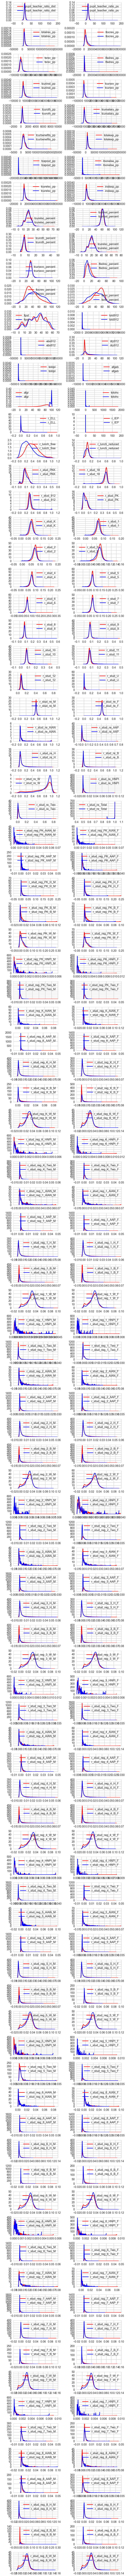

In [34]:
fig, axs = plt.subplots(100, 2, figsize=(10,200), tight_layout=True)

for item, ax in zip(filtereddistrict[STANDARDIZABLE], axs.flat):
    sns.kdeplot(filtereddistrict[filtereddistrict["RESP_High_Graduation"]==0][item], ax=ax, color='r')
    sns.kdeplot(filtereddistrict[filtereddistrict["RESP_High_Graduation"]==1][item], ax=ax, color='b')

In [51]:
dftouse = filtereddistrict.copy(deep=True)

In [52]:
dftouse.drop('agency', axis=1, inplace=True)
dftouse.drop('state', axis=1, inplace=True)
dftouse.drop('state_abbr', axis=1, inplace=True)
dftouse.drop('agency_id_nces', axis=1, inplace=True)
dftouse.drop('county', axis=1, inplace=True)
dftouse.drop('county_number', axis=1, inplace=True)
dftouse.drop('report_years', axis=1, inplace=True)
dftouse.drop('no_report_years', axis=1, inplace=True)
dftouse.drop('address', axis=1, inplace=True)
dftouse.drop('city', axis=1, inplace=True)
dftouse.drop('add_state', axis=1, inplace=True)
dftouse.drop('zipcode', axis=1, inplace=True)
dftouse.drop('latitude', axis=1, inplace=True)
dftouse.drop('longitude', axis=1, inplace=True)
dftouse.drop('agency_id_state', axis=1, inplace=True)
dftouse.drop('congressional_code', axis=1, inplace=True)
dftouse.drop('census_id', axis=1, inplace=True)
dftouse.drop('offered_g_lowest', axis=1, inplace=True)

In [53]:
filtereddistrict.to_csv("data/finaldata/dftouse.csv")

In [40]:
dftouse.shape

(10785, 393)

In [42]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)

In [43]:
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [44]:
mask

array([ True, False, False, ...,  True, False,  True], dtype=bool)

In [45]:
mask.shape, mask.sum()

((10785,), 7549)

In [46]:
from sklearn.preprocessing import StandardScaler

trainDS = dftouse[mask]
testDS = dftouse[~mask]

scaler = StandardScaler().fit(trainDS[STANDARDIZABLE])
scalerTwo = StandardScaler().fit(testDS[STANDARDIZABLE])

dftouse.ix[mask, STANDARDIZABLE] = scaler.transform(trainDS[STANDARDIZABLE])
dftouse.ix[~mask, STANDARDIZABLE] = scalerTwo.transform(testDS[STANDARDIZABLE])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
lcols=list(filtereddistrict.columns)
lcols.remove('RESP_High_Graduation')
lcols.remove('RESP_Low_Graduation')
print len(lcols)